In [1]:
import pandas as pd
import glob
import numpy as np
import seaborn as sns
from IPython.display import display

pd.options.display.max_columns = None

In [2]:
EXPERIMENT='run5'

In [3]:
data_char_df = pd.read_json(glob.glob("./data_characteristics/*.log")[0], lines=True)

dfs = []
for file in glob.glob(f"./{EXPERIMENT}/*.log"):
    dfs += [pd.read_json(file, lines=True)]

df = pd.concat(dfs)
df = df[df.times_mean != -1] # drop baseline materialize
df = df[~df.operator.apply(lambda operator_str: any([x in operator_str for x in ['fail', 'Materialization', 'Noop']]))]
df = df.reset_index(drop=True)
pre_df = df.copy().drop(columns=['join'])

if 'data_characteristics' in df.columns and isinstance(df.data_characteristics.iloc[0], dict):
    # explode data_char dict
    pre_df = pre_df.merge(pd.json_normalize(pre_df.data_characteristics), left_index=True, right_index=True)
    ...

display(df.head())
df = df.explode('times').groupby(['dataset', 'num_cores', 'model', 'operator']).agg({'times_mean': np.mean, 'times_std': np.std})
display(df.head())
df = df.reset_index()
if EXPERIMENT ==  'run1':
    df = df.merge(data_char_df, on='dataset', how='left')

df = df.merge(pre_df.drop(columns=['times_mean', 'times_std']), on=['dataset', 'num_cores', 'model', 'operator'], how='left')


baseline_lookup_dict = {(dataset, operator, num_cores): mean_time for (dataset, operator, num_cores, mean_time) in df[((df.model == 'materialized') | (df.model == 'baseline'))][['dataset', 'operator', 'num_cores', 'times_mean']].values}
def calc_speedup(row) -> float:
    if row[1] == 'Materialization':
        return 0.0
    baseline = baseline_lookup_dict[(row[0], row[1], row[2])]
    return baseline / row[3]

df['speedup'] = df[['dataset', 'operator', 'num_cores', 'times_mean']].apply(calc_speedup, axis=1)

T_lookup = dict(df[(df.model == 'materialized') & (df.operator == 'Column summation')][['dataset', 'complexity']].values)
S_lookup = dict(df[(df.model == 'factorized') & (df.operator == 'Column summation')][['dataset', 'complexity']].values)
df['T_nonzero'] = df.dataset.apply(lambda x: T_lookup[x])
df['S_nonzero'] = df.dataset.apply(lambda x: S_lookup[x])
df['nonzero_ratio'] = df.T_nonzero / df.S_nonzero


materialized_complexity_dict = {(dataset, operator): complexity for dataset, operator, complexity in df[df.model == 'materialized'][['dataset', 'operator', 'complexity']].values}
def calc_complexity_ratio(row):
    if row[1] == 'Materialization':
        return None

    return materialized_complexity_dict[(row[0], row[1])] / row[2]

df['complexity_ratio'] = df[['dataset', 'operator', 'complexity']].apply(calc_complexity_ratio, axis=1)
df['operator_type'] = df.operator.apply(lambda x: 'ML' if x in ['Gaussian', 'KMeans', 'Linear Regression', 'Logistic Regression'] else 'LA')

print(df.dtypes)
display(df.describe())
display(df.head())

dataset    join  \
0  /user/data/generated/r_T=10000-c_T=10-rho_c_S=...  preset   
1  /user/data/generated/r_T=10000-c_T=10-rho_c_S=...  preset   
2  /user/data/generated/r_T=10000-c_T=10-rho_c_S=...  preset   
3  /user/data/generated/r_T=10000-c_T=10-rho_c_S=...  preset   
4  /user/data/generated/r_T=10000-c_T=10-rho_c_S=...  preset   

           operator         model  tuple_ratio  feature_ratio  cardinality_T  \
0     Left multiply  materialized         1.25            8.0          10000   
1     Left multiply    factorized         1.25            8.0          10000   
2     Row summation  materialized         1.25            8.0          10000   
3     Row summation    factorized         1.25            8.0          10000   
4  Column summation  materialized         1.25            8.0          10000   

   cardinality_S  complexity  selectivity  \
0          18000     90000.0          1.8   
1          18000     74000.0          1.8   
2          18000     90000.0          1.8   
3          18000     74000.0          1.8   
4          18000     90000.0          1.8   

                                               times  num_cores  \
0  [0.00030318000062800005, 0.000200469992705, 0....         32   
1  [0.000392889996874, 0.00031189000583200003, 0....         32   
2  [0.0005193399993, 0.00033962099405400003, 0.00...         32   
3  [0.0008726800006110001, 0.0005885999999, 0.000...         32   
4  [0.0007704390009160001, 0.0005275500006970001,...         32   

                                data_characteristics  times_std  times_mean  
0  {'r_T': 10000, 'c_T': 10, 'r_S': 10000, 'c_S':...   0.000040    0.000130  
1  {'r_T': 10000, 'c_T': 10, 'r_S': 10000, 'c_S':...   0.000041    0.000217  
2  {'r_T': 10000, 'c_T': 10, 'r_S': 10000, 'c_S':...   0.000042    0.000311  
3  {'r_T': 10000, 'c_T': 10, 'r_S': 10000, 'c_S':...   0.000059    0.000578  
4  {'r_T': 10000, 'c_T': 10, 'r_S': 10000, 'c_S':...   0.000061    0.000487

times_mean  \
dataset                                            num_cores model      operator                         
/user/data/generated/r_T=1000-c_T=10-rho_c_S=0.... 4         factorized Column summation      0.002487   
                                                                        Column summation T    0.000483   
                                                                        Gaussian              0.068638   
                                                                        KMeans                0.177921   
                                                                        LMM                   0.023017   

                                                                                            times_std  
dataset                                            num_cores model      operator                       
/user/data/generated/r_T=1000-c_T=10-rho_c_S=0.... 4         factorized Column summation          0.0  
                                                                        Column summation T        0.0  
                                                                        Gaussian                  0.0  
                                                                        KMeans                    0.0  
                                                                        LMM                       0.0

dataset                  object
num_cores                 int64
model                    object
operator                 object
times_mean              float64
times_std               float64
tuple_ratio             float64
feature_ratio           float64
cardinality_T             int64
cardinality_S             int64
complexity              float64
selectivity             float64
times                    object
data_characteristics     object
r_T                       int64
c_T                       int64
r_S                       int64
c_S                       int64
r_R                      object
c_R                      object
p_S_cfg                 float64
n_row_matches             int64
n_col_matches             int64
n_target_matches          int64
join                     object
n_S                       int64
n_R                       int64
speedup                 float64
T_nonzero               float64
S_nonzero               float64
nonzero_ratio           float64
complexi

num_cores    times_mean  times_std   tuple_ratio  feature_ratio  \
count  17920.000000  17920.000000    17920.0  17920.000000   17920.000000   
mean      15.000000      0.034501        0.0      4.725000       2.531250   
std       10.724105      0.124817        0.0      4.307381       3.177616   
min        4.000000      0.000014        0.0      1.125000       0.125000   
25%        7.000000      0.000262        0.0      1.250000       0.781250   
50%       12.000000      0.001355        0.0      1.250000       1.000000   
75%       20.000000      0.015545        0.0     10.000000       2.750000   
max       32.000000      2.512919        0.0     10.000000       8.000000   

       cardinality_T  cardinality_S    complexity   selectivity           r_T  \
count   17920.000000   17920.000000  1.792000e+04  17920.000000  17920.000000   
mean     5500.000000    8250.000000  1.808535e+06      1.500000   5500.000000   
std      4500.125563    7142.782865  4.409851e+06      0.328643   4500.125563   
min      1000.000000    1100.000000  1.100000e+03      1.100000   1000.000000   
25%      1000.000000    1700.000000  4.980000e+04      1.100000   1000.000000   
50%      5500.000000    6400.000000  1.910000e+05      1.700000   5500.000000   
75%     10000.000000   17000.000000  1.217000e+06      1.800000  10000.000000   
max     10000.000000   18000.000000  2.760000e+07      1.800000  10000.000000   

                c_T          r_S           c_S       p_S_cfg  n_row_matches  \
count  17920.000000  17920.00000  17920.000000  17920.000000   17920.000000   
mean      55.000000   5390.00000     24.750000      0.250000    2750.000000   
std       45.001256   4419.27481     32.074053      0.250007    3243.005842   
min       10.000000    900.00000      1.000000      0.000000     100.000000   
25%       10.000000   1000.00000      6.250000      0.000000     700.000000   
50%       55.000000   5000.00000      9.000000      0.250000     900.000000   
75%      100.000000  10000.00000     27.500000      0.500000    7000.000000   
max      100.000000  10000.00000     80.000000      0.500000    8000.000000   

       n_col_matches  n_target_matches      n_S      n_R       speedup  \
count   17920.000000      17920.000000  17920.0  17920.0  17920.000000   
mean       -5.500000       2519.000000      1.0      1.0      1.263573   
std        35.462236       3098.067882      0.0      0.0      4.567088   
min       -80.000000        180.000000      1.0      1.0      0.001965   
25%       -10.000000        200.000000      1.0      1.0      0.413324   
50%        -4.500000       1350.000000      1.0      1.0      1.000000   
75%         0.750000       2000.000000      1.0      1.0      1.000000   
max        60.000000       9000.000000      1.0      1.0    176.313280   

            T_nonzero      S_nonzero  nonzero_ratio  complexity_ratio  
count    17920.000000   17920.000000   17920.000000      17920.000000  
mean    196979.750000  155416.250000       1.610197          1.127983  
std     306244.887337  258830.765828       1.233363          0.639050  
min       1900.000000    1100.000000       1.020455          0.665714  
25%      13075.000000    9550.000000       1.059667          1.000000  
50%      82800.000000   61602.000000       1.177297          1.000000  
75%     110250.000000   96000.000000       1.222297          1.047368  
max    1000000.000000  960000.000000       6.538462          6.538462

dataset  num_cores       model  \
0  /user/data/generated/r_T=1000-c_T=10-rho_c_S=0...          4  factorized   
1  /user/data/generated/r_T=1000-c_T=10-rho_c_S=0...          4  factorized   
2  /user/data/generated/r_T=1000-c_T=10-rho_c_S=0...          4  factorized   
3  /user/data/generated/r_T=1000-c_T=10-rho_c_S=0...          4  factorized   
4  /user/data/generated/r_T=1000-c_T=10-rho_c_S=0...          4  factorized   

             operator  times_mean  times_std  tuple_ratio  feature_ratio  \
0    Column summation    0.002487        0.0         10.0            1.0   
1  Column summation T    0.000483        0.0         10.0            1.0   
2            Gaussian    0.068638        0.0         10.0            1.0   
3              KMeans    0.177921        0.0         10.0            1.0   
4                 LMM    0.023017        0.0         10.0            1.0   

   cardinality_T  cardinality_S  complexity  selectivity  \
0           1000           1100      1100.0          1.1   
1           1000           1100      1100.0          1.1   
2           1000           1100     12800.0          1.1   
3           1000           1100     21400.0          1.1   
4           1000           1100     33000.0          1.1   

                                               times  \
0  [0.0005943199939790001, 0.00048822999815400006...   
1  [0.000670410008751, 0.00051092999638, 0.000480...   
2  [0.059039865998784004, 0.10091122299490901, 0....   
3  [0.03270417699241, 0.19848544600245002, 0.3775...   
4  [0.007765138987451001, 0.010540168994339, 0.00...   

                                data_characteristics   r_T  c_T   r_S  c_S  \
0  {'r_T': 1000, 'c_T': 10, 'r_S': 1000, 'c_S': 1...  1000   10  1000    1   
1  {'r_T': 1000, 'c_T': 10, 'r_S': 1000, 'c_S': 1...  1000   10  1000    1   
2  {'r_T': 1000, 'c_T': 10, 'r_S': 1000, 'c_S': 1...  1000   10  1000    1   
3  {'r_T': 1000, 'c_T': 10, 'r_S': 1000, 'c_S': 1...  1000   10  1000    1   
4  {'r_T': 1000, 'c_T': 10, 'r_S': 1000, 'c_S': 1...  1000   10  1000    1   

     r_R  c_R  p_S_cfg  n_row_matches  n_col_matches  n_target_matches   join  \
0  [100]  [1]      0.0            100             -8               900  inner   
1  [100]  [1]      0.0            100             -8               900  inner   
2  [100]  [1]      0.0            100             -8               900  inner   
3  [100]  [1]      0.0            100             -8               900  inner   
4  [100]  [1]      0.0            100             -8               900  inner   

   n_S  n_R   speedup  T_nonzero  S_nonzero  nonzero_ratio  complexity_ratio  \
0    1    1  0.062912     2000.0     1100.0       1.818182          1.818182   
1    1    1  0.317203     2000.0     1100.0       1.818182          1.818182   
2    1    1  0.246543     2000.0     1100.0       1.818182          1.250000   
3    1    1  0.072170     2000.0     1100.0       1.818182          1.308411   
4    1    1  0.001965     2000.0     1100.0       1.818182          1.212121   

  operator_type  
0            LA  
1            LA  
2            ML  
3            ML  
4            LA

In [30]:
df.c_T.unique()

array([ 10, 100])

In [36]:
dfs = df[(df.num_cores == 4) & (df.model == 'factorized')]
a = dfs[dfs.dataset == dfs.dataset.iloc[0].replace("r_T=1000", "r_T=10000")]
c = dfs[dfs.dataset == dfs.dataset.iloc[0].replace("c_T=10", "c_T=100")]
b = dfs[dfs.dataset == dfs.dataset.iloc[0]]
pd.concat([a,b,c ])[['operator', 'r_T', 'c_T', 'complexity', 'complexity_ratio', 'T_nonzero', 'S_nonzero', 'operator_type']].sort_values(['operator', 'T_nonzero'])

operator    r_T  c_T  complexity  complexity_ratio  \
0        Column summation   1000   10      1100.0          1.818182   
8960     Column summation  10000   10     11000.0          1.818182   
4480     Column summation   1000  100     11000.0          1.818182   
1      Column summation T   1000   10      1100.0          1.818182   
8961   Column summation T  10000   10     11000.0          1.818182   
4481   Column summation T   1000  100     11000.0          1.818182   
2                Gaussian   1000   10     12800.0          1.250000   
8962             Gaussian  10000   10    128000.0          1.250000   
4482             Gaussian   1000  100    128000.0          1.250000   
3                  KMeans   1000   10     21400.0          1.308411   
8963               KMeans  10000   10    214000.0          1.308411   
4483               KMeans   1000  100    214000.0          1.308411   
4                     LMM   1000   10     33000.0          1.212121   
8964                  LMM  10000   10    330000.0          1.212121   
4484                  LMM   1000  100    330000.0          1.212121   
5                   LMM T   1000   10     31000.0          1.290323   
8965                LMM T  10000   10    310000.0          1.290323   
4485                LMM T   1000  100    310000.0          1.290323   
6           Left multiply   1000   10      1100.0          1.818182   
8966        Left multiply  10000   10     11000.0          1.818182   
4486        Left multiply   1000  100     11000.0          1.818182   
7         Left multiply T   1000   10      1100.0          1.818182   
8967      Left multiply T  10000   10     11000.0          1.818182   
4487      Left multiply T   1000  100     11000.0          1.818182   
8       Linear Regression   1000   10      6400.0          1.250000   
8968    Linear Regression  10000   10     64000.0          1.250000   
4488    Linear Regression   1000  100     64000.0          1.250000   
9     Logistic Regression   1000   10      6400.0          1.250000   
8969  Logistic Regression  10000   10     64000.0          1.250000   
4489  Logistic Regression   1000  100     64000.0          1.250000   
10                    RMM   1000   10     31000.0          1.290323   
8970                  RMM  10000   10    310000.0          1.290323   
4490                  RMM   1000  100    310000.0          1.290323   
11                  RMM T   1000   10     33000.0          1.212121   
8971                RMM T  10000   10    330000.0          1.212121   
4491                RMM T   1000  100    330000.0          1.212121   
12          Row summation   1000   10      1100.0          1.818182   
8972        Row summation  10000   10     11000.0          1.818182   
4492        Row summation   1000  100     11000.0          1.818182   
13        Row summation T   1000   10      1100.0          1.818182   
8973      Row summation T  10000   10     11000.0          1.818182   
4493      Row summation T   1000  100     11000.0          1.818182   

      T_nonzero  S_nonzero operator_type  
0        2000.0     1100.0            LA  
8960    20000.0    11000.0            LA  
4480    20000.0    11000.0            LA  
1        2000.0     1100.0            LA  
8961    20000.0    11000.0            LA  
4481    20000.0    11000.0            LA  
2        2000.0     1100.0            ML  
8962    20000.0    11000.0            ML  
4482    20000.0    11000.0            ML  
3        2000.0     1100.0            ML  
8963    20000.0    11000.0            ML  
4483    20000.0    11000.0            ML  
4        2000.0     1100.0            LA  
8964    20000.0    11000.0            LA  
4484    20000.0    11000.0            LA  
5        2000.0     1100.0            LA  
8965    20000.0    11000.0            LA  
4485    20000.0    11000.0            LA  
6        2000.0     1100.0            LA  
8966    20000.0    11000.0            LA  
4486    20000.0    11000.0            LA  
7        2000.0  

In [16]:
df[df.dataset == df.dataset.iloc[0]][['operator', 'complexity', 'complexity_ratio']]

operator  complexity  complexity_ratio
0       Column summation      1100.0          1.818182
1     Column summation T      1100.0          1.818182
2               Gaussian     12800.0          1.250000
3                 KMeans     21400.0          1.308411
4                    LMM     33000.0          1.212121
..                   ...         ...               ...
107  Logistic Regression      8000.0          1.000000
108                  RMM     40000.0          1.000000
109                RMM T     40000.0          1.000000
110        Row summation      2000.0          1.000000
111      Row summation T      2000.0          1.000000

[112 rows x 3 columns]

<Axes: xlabel='operator', ylabel='complexity_ratio'>

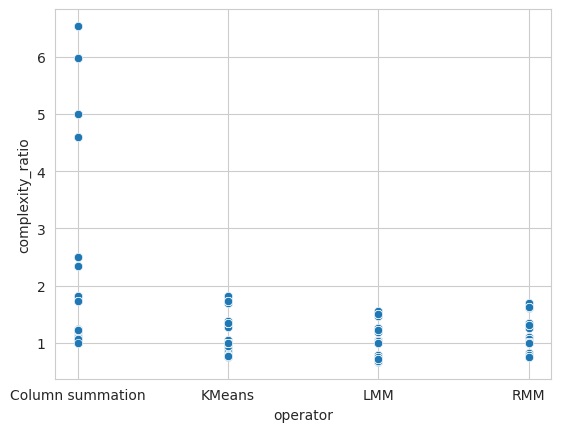

In [12]:
sns.scatterplot(data=df[df.operator.apply(lambda x: x in ['Column summation', 'LMM', 'KMeans', 'RMM'])], x='operator', y='complexity_ratio')

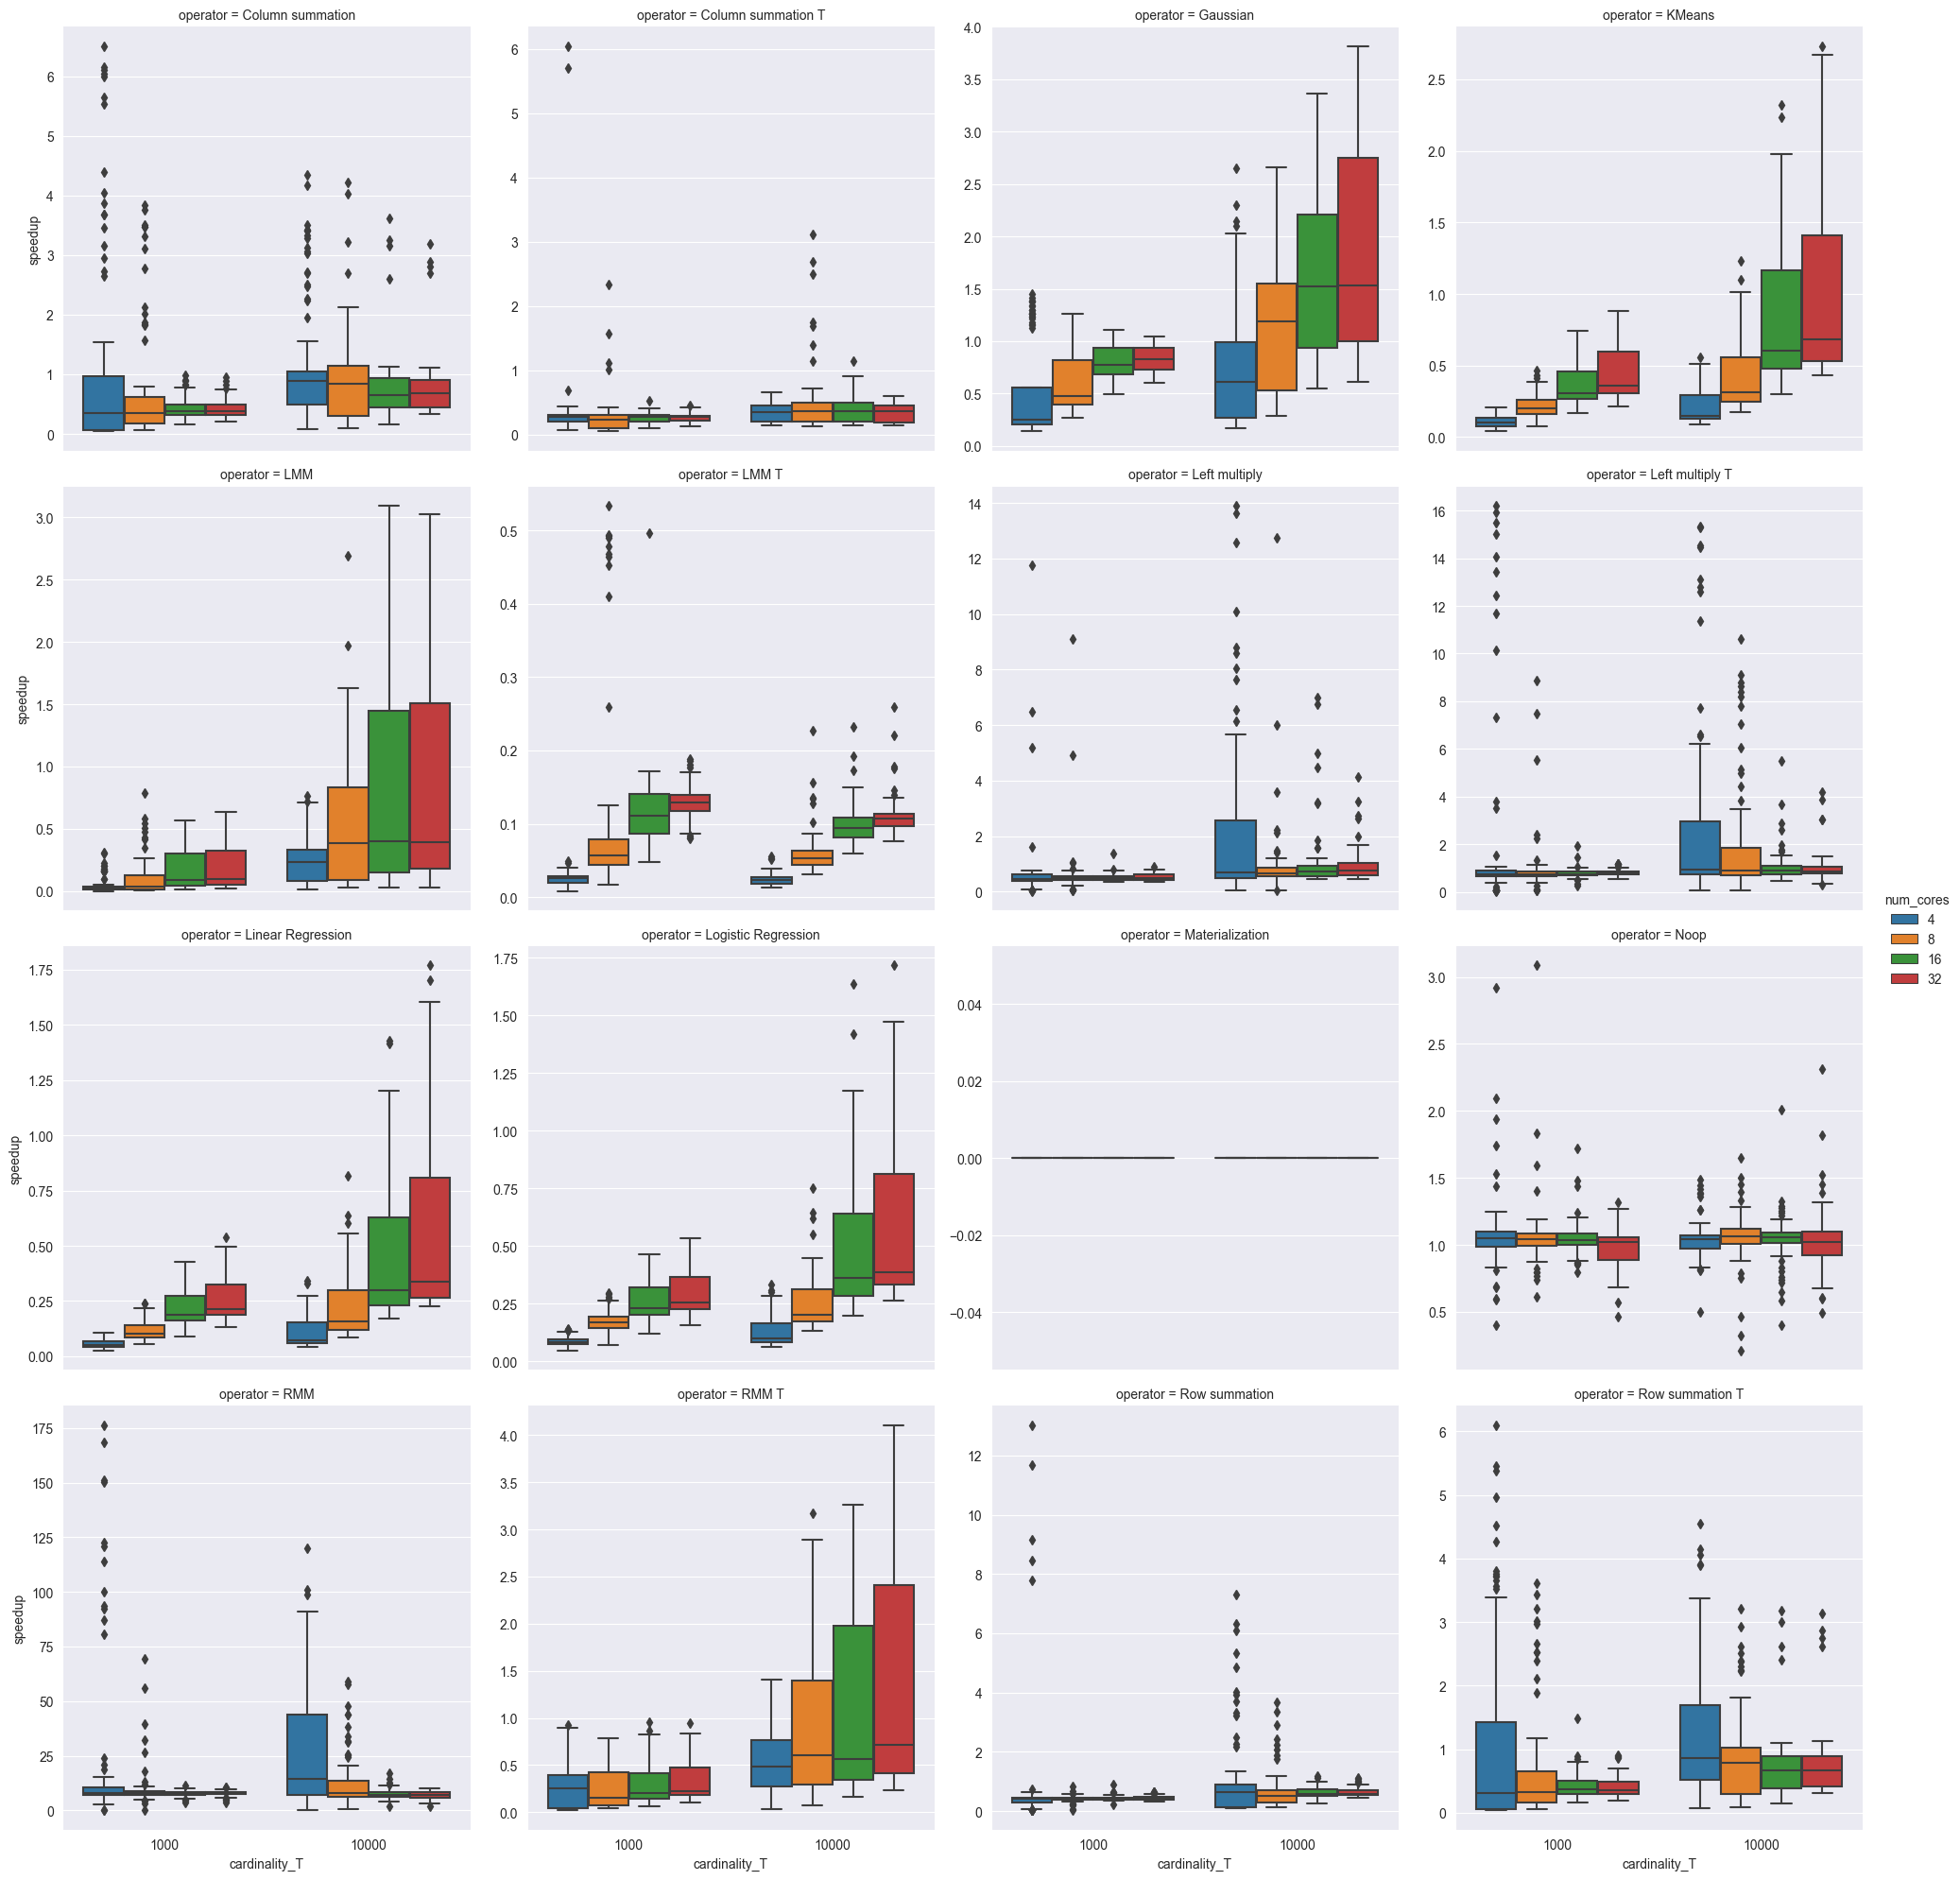

In [82]:
sns.catplot(kind='box', data=df[df.model == 'factorized'], hue='num_cores', y='speedup', x='cardinality_T', col='operator', col_wrap=4, sharey=False)

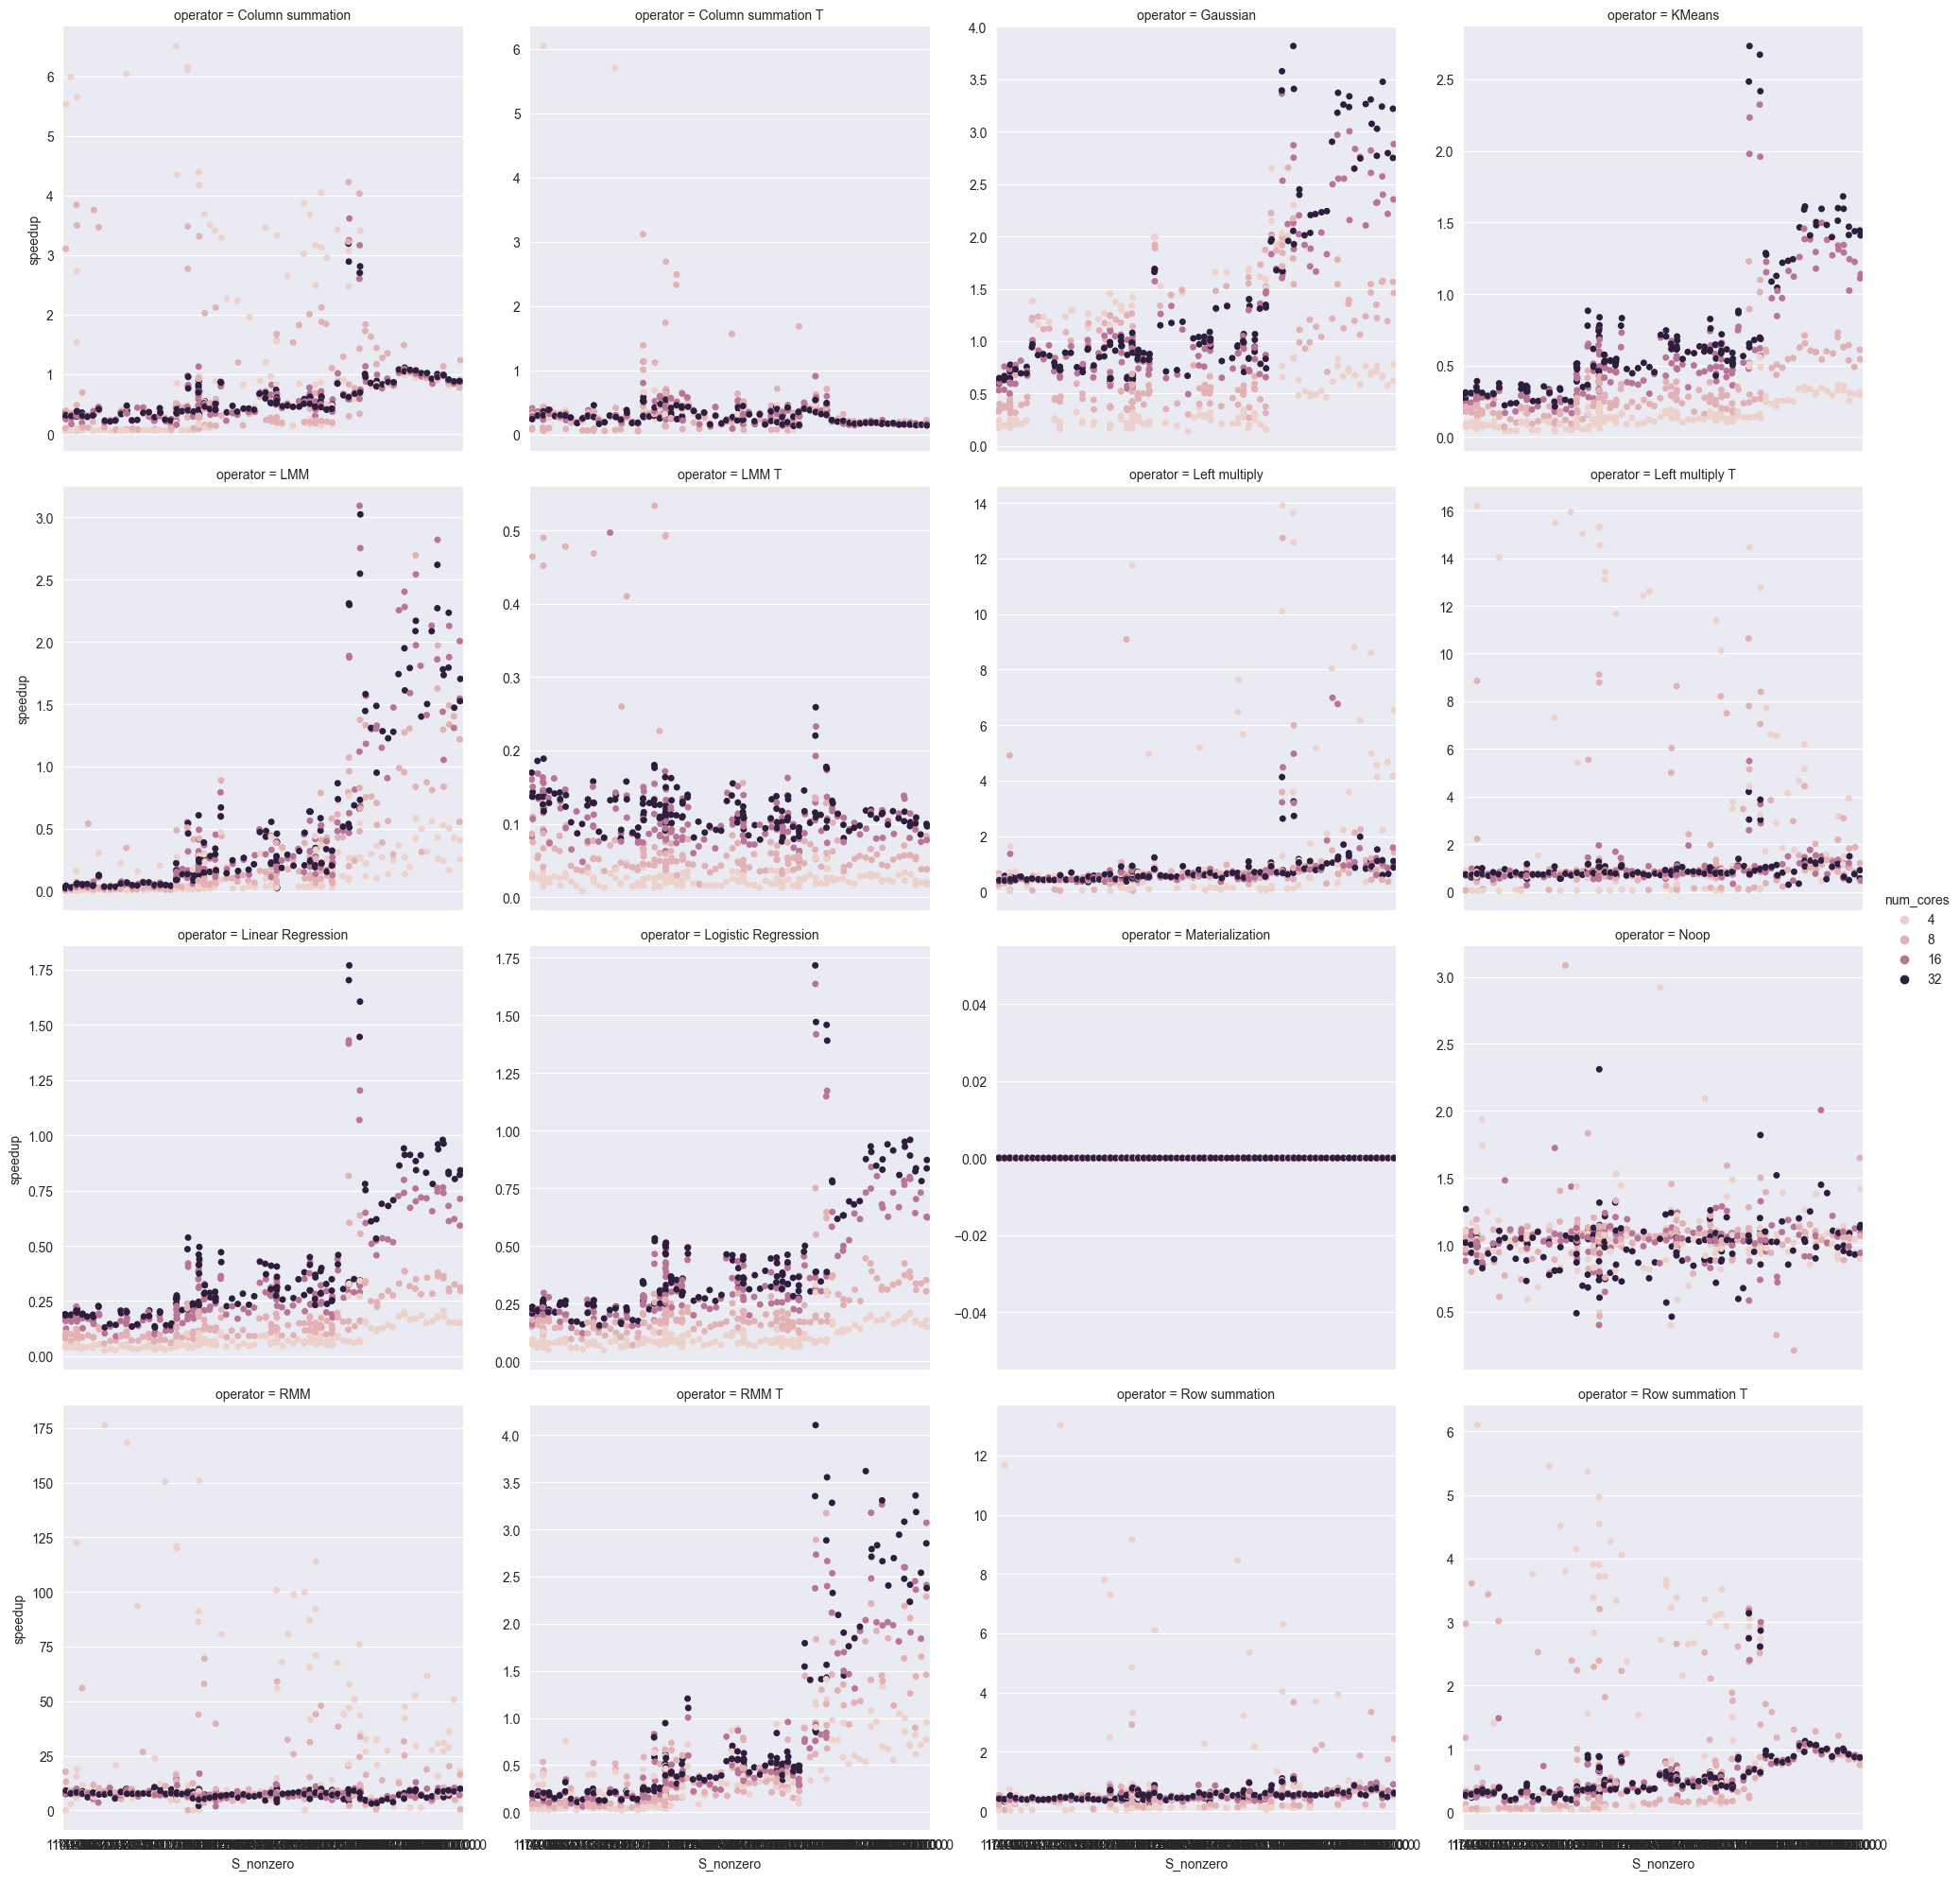

In [86]:
sns.catplot(data=df[df.model == 'factorized'], hue='num_cores', y='speedup', x='S_nonzero', col='operator', col_wrap=4, sharey=False)

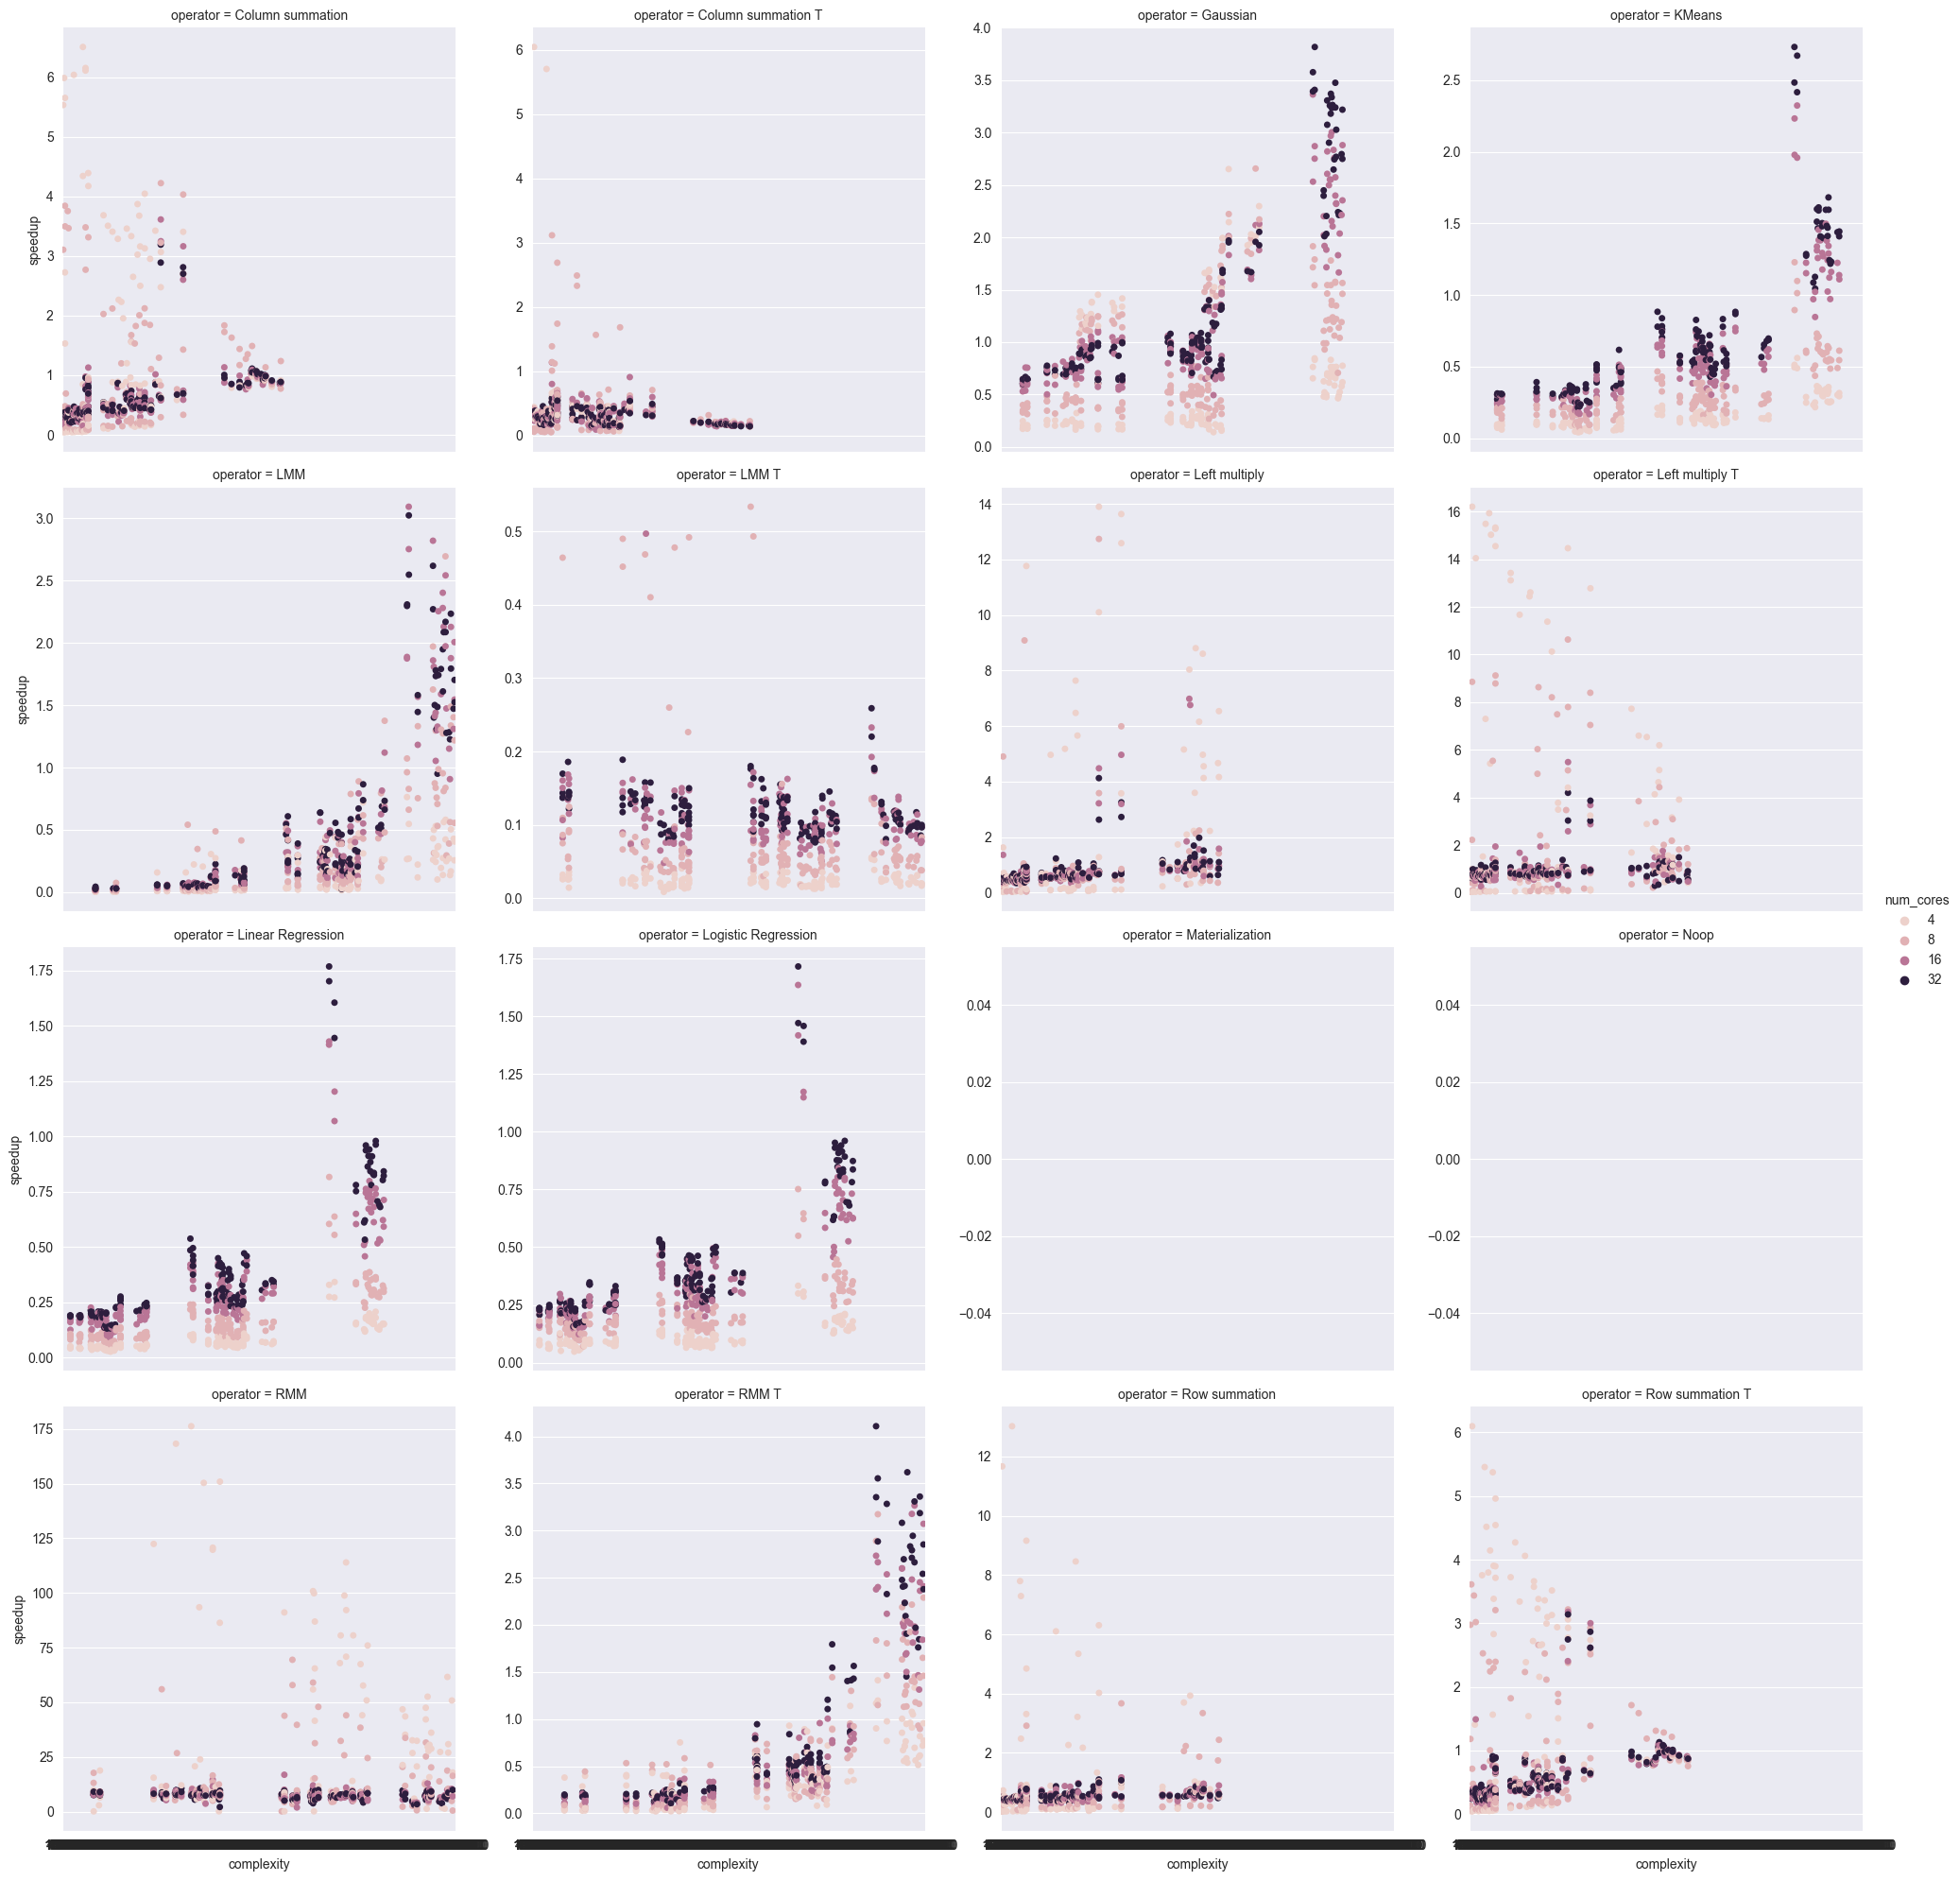

In [91]:
sns.catplot(data=df[df.model == 'factorized'], hue='num_cores', y='speedup', x='complexity', col='operator', col_wrap=4, sharey=False)

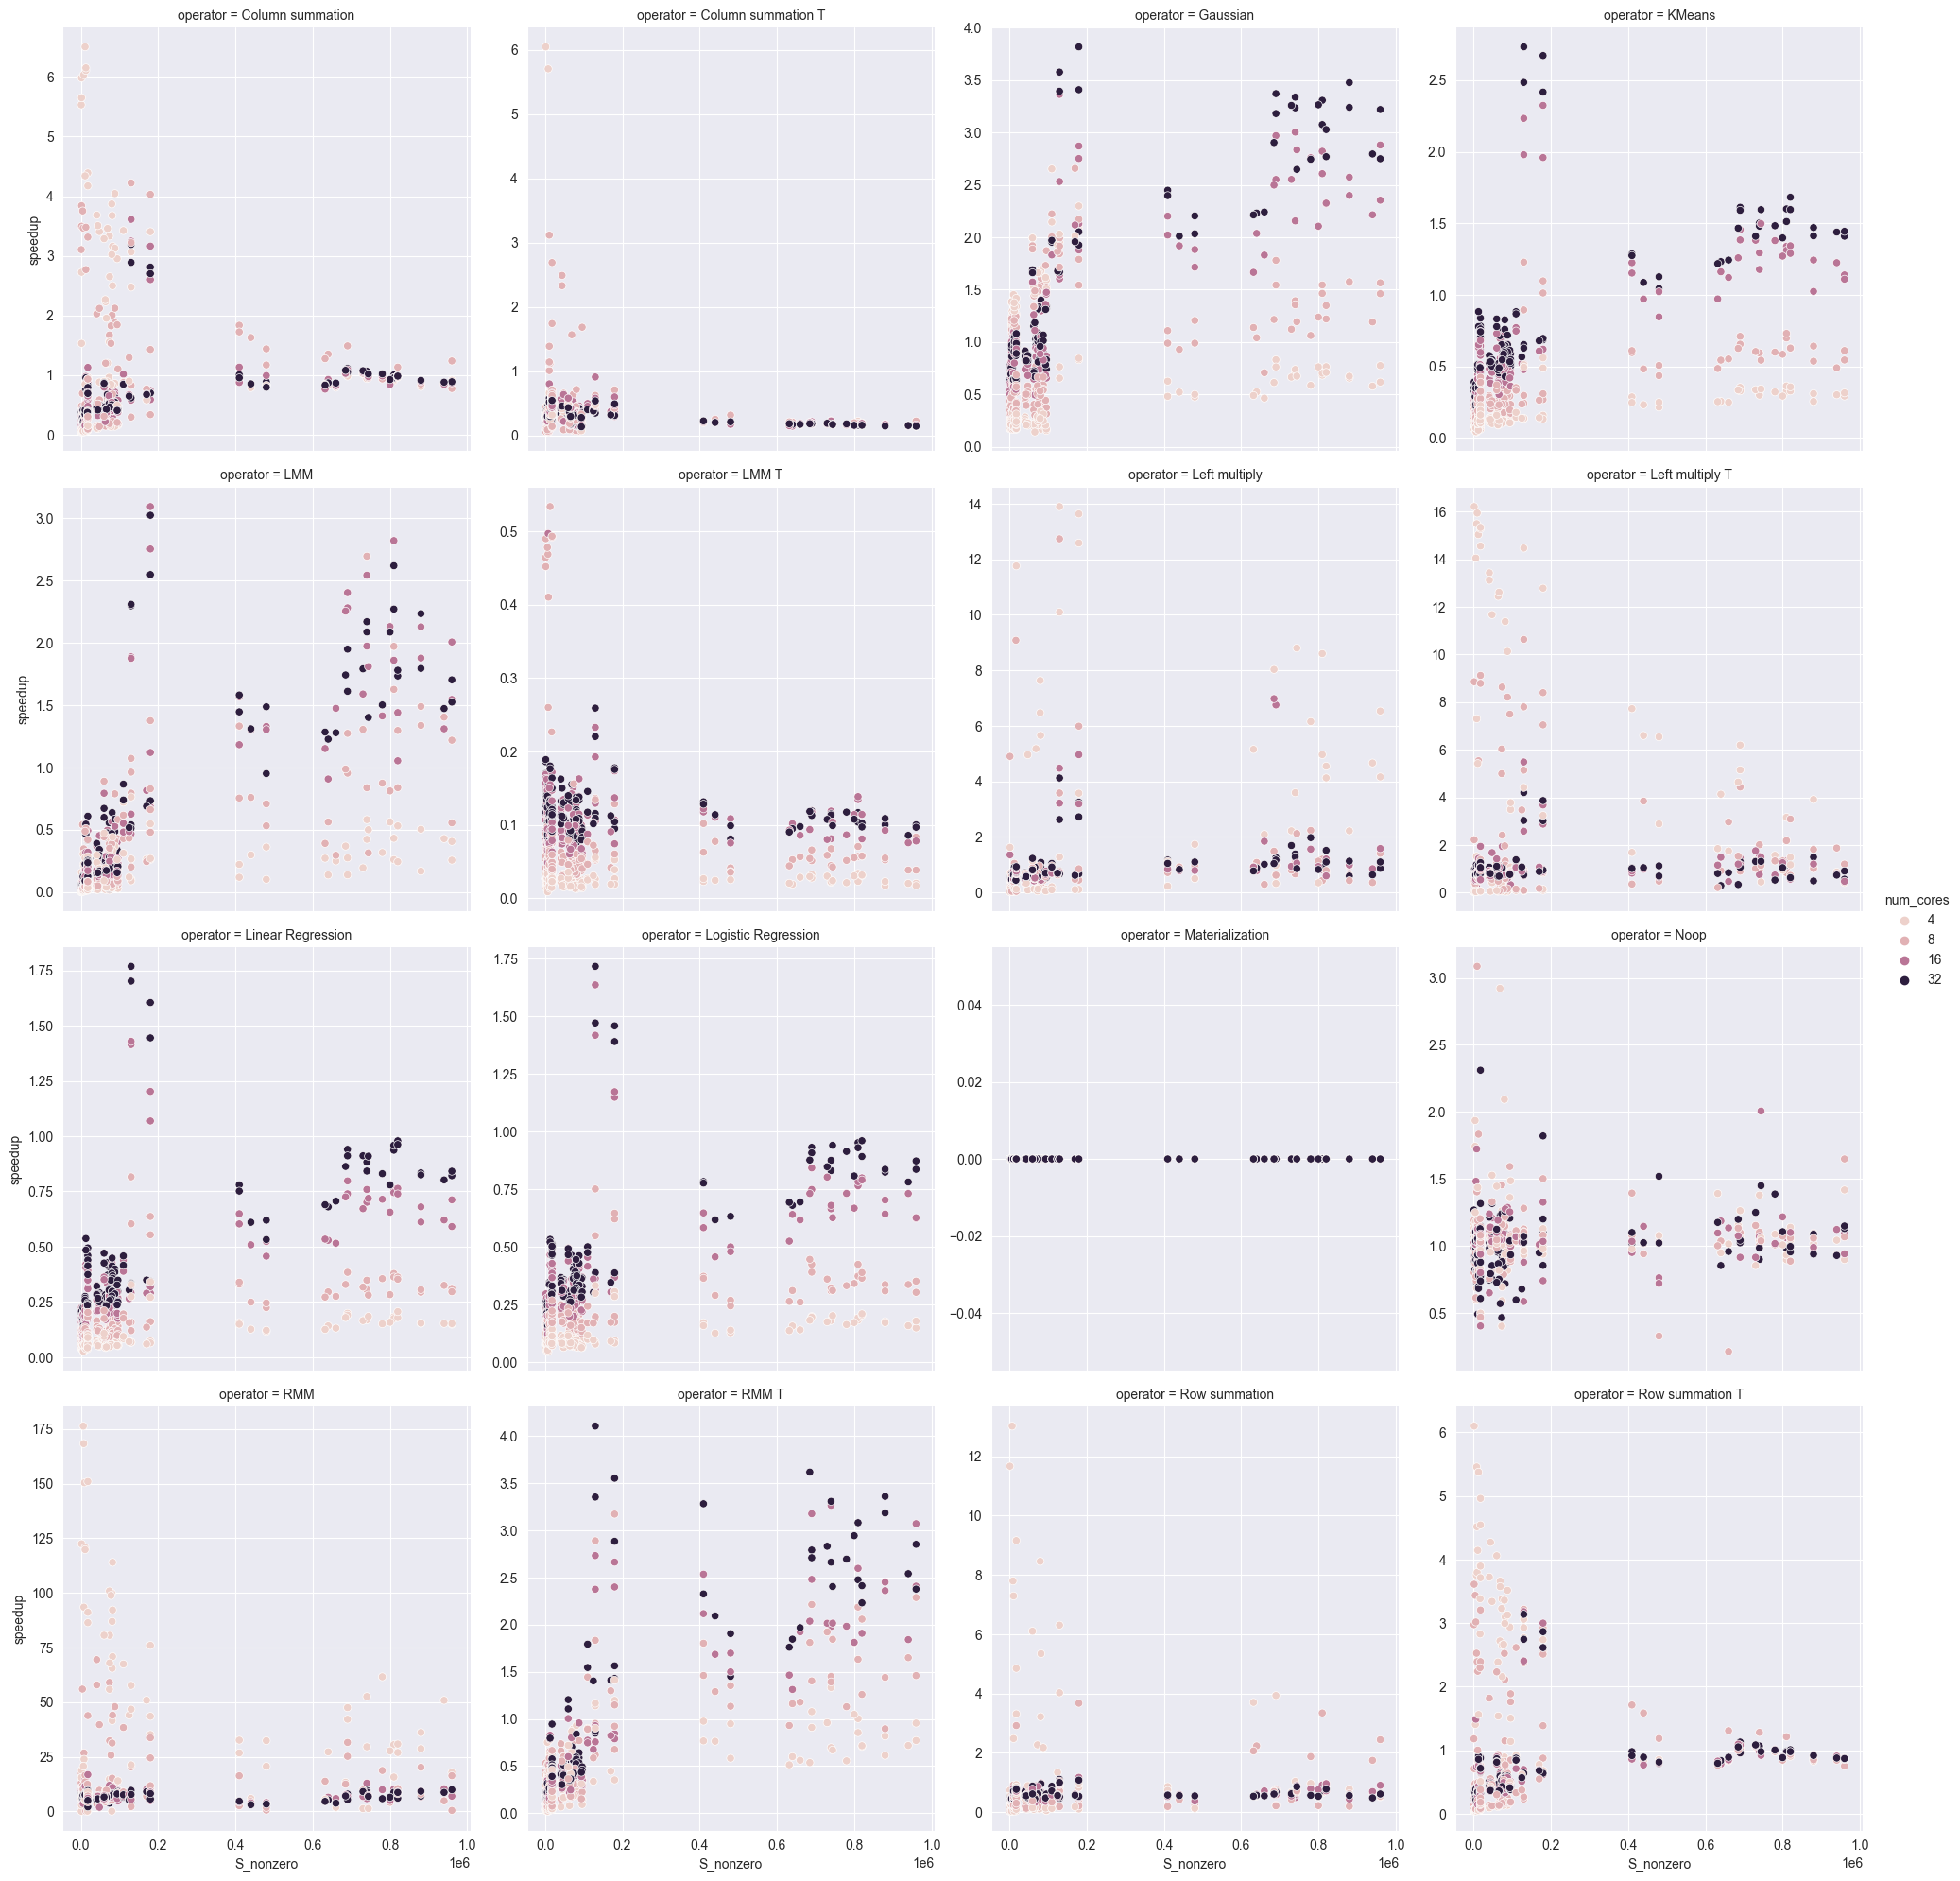

In [103]:
# Above like plot but with lineplot and errorbars.
sns.relplot(kind='scatter', data=df[df.model == 'factorized'], hue='num_cores', y='speedup', x='S_nonzero', col='operator', col_wrap=4,facet_kws={'sharey': False, 'sharex': True})

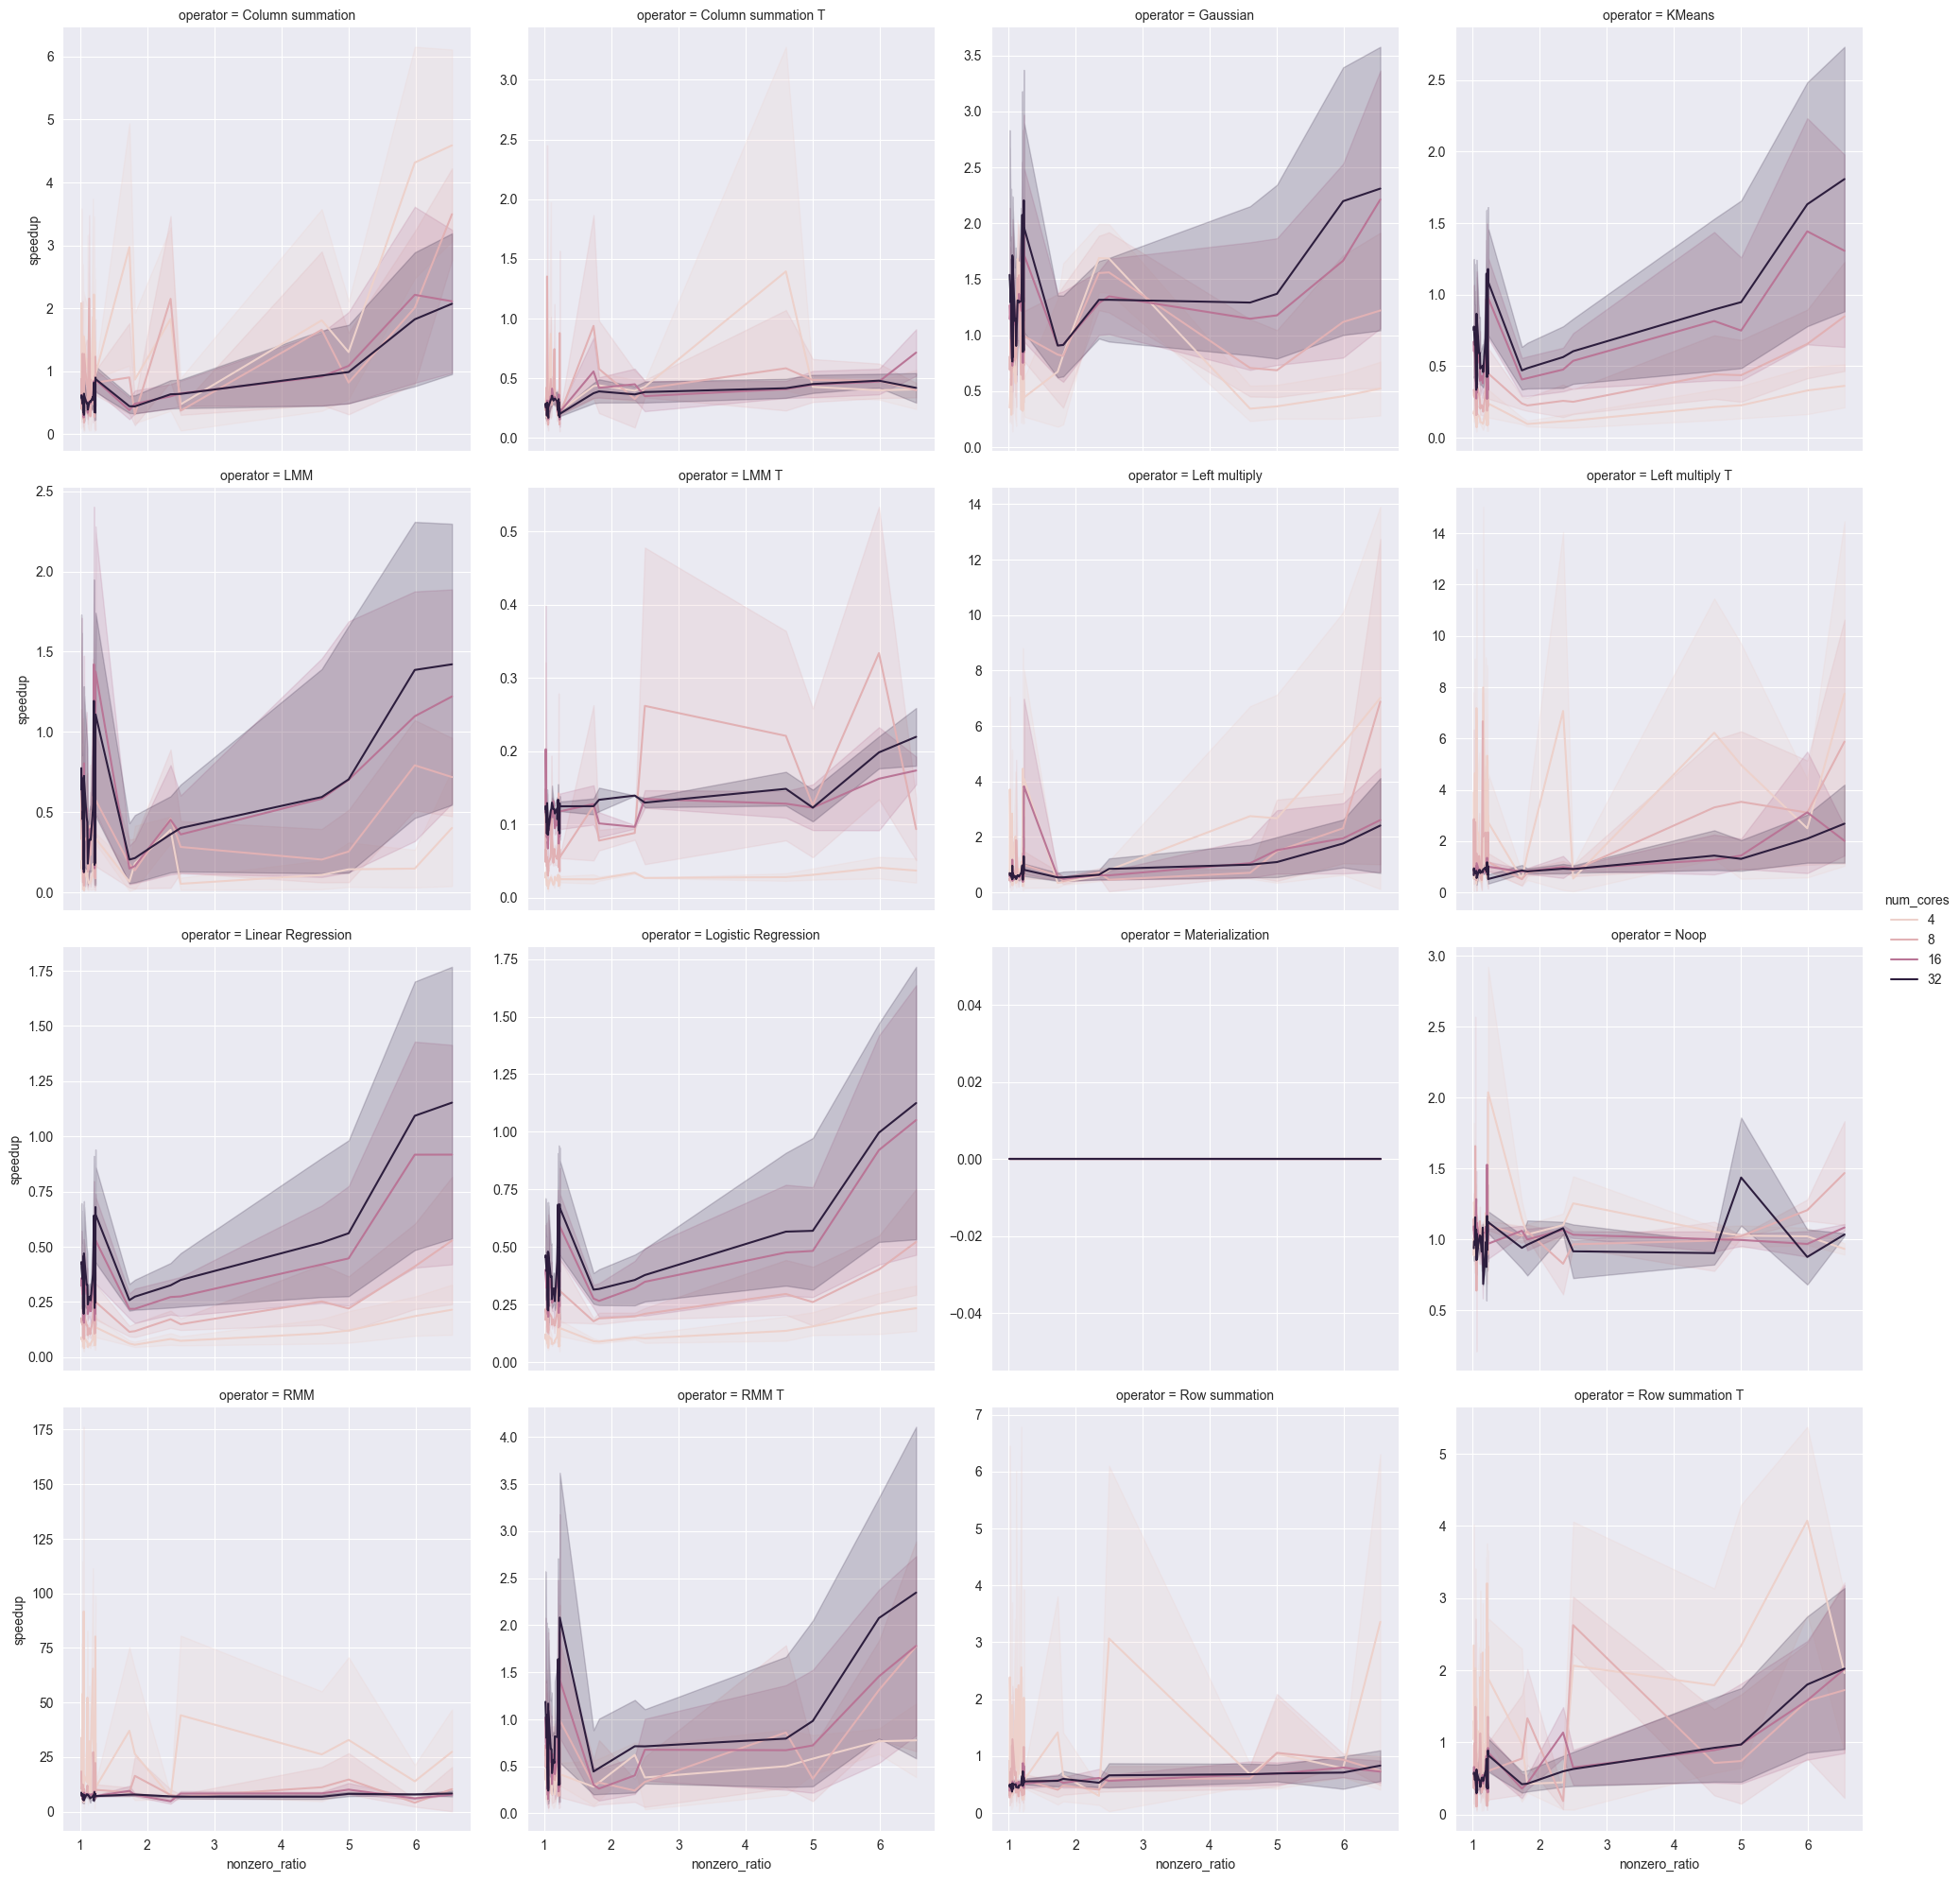

In [107]:
# calculate redundancy in T. Higher value means more elements in T
sns.relplot(kind='line', data=df[df.model == 'factorized'], hue='num_cores', y='speedup', x='nonzero_ratio', col='operator', col_wrap=4,facet_kws={'sharey': False, 'sharex': True})

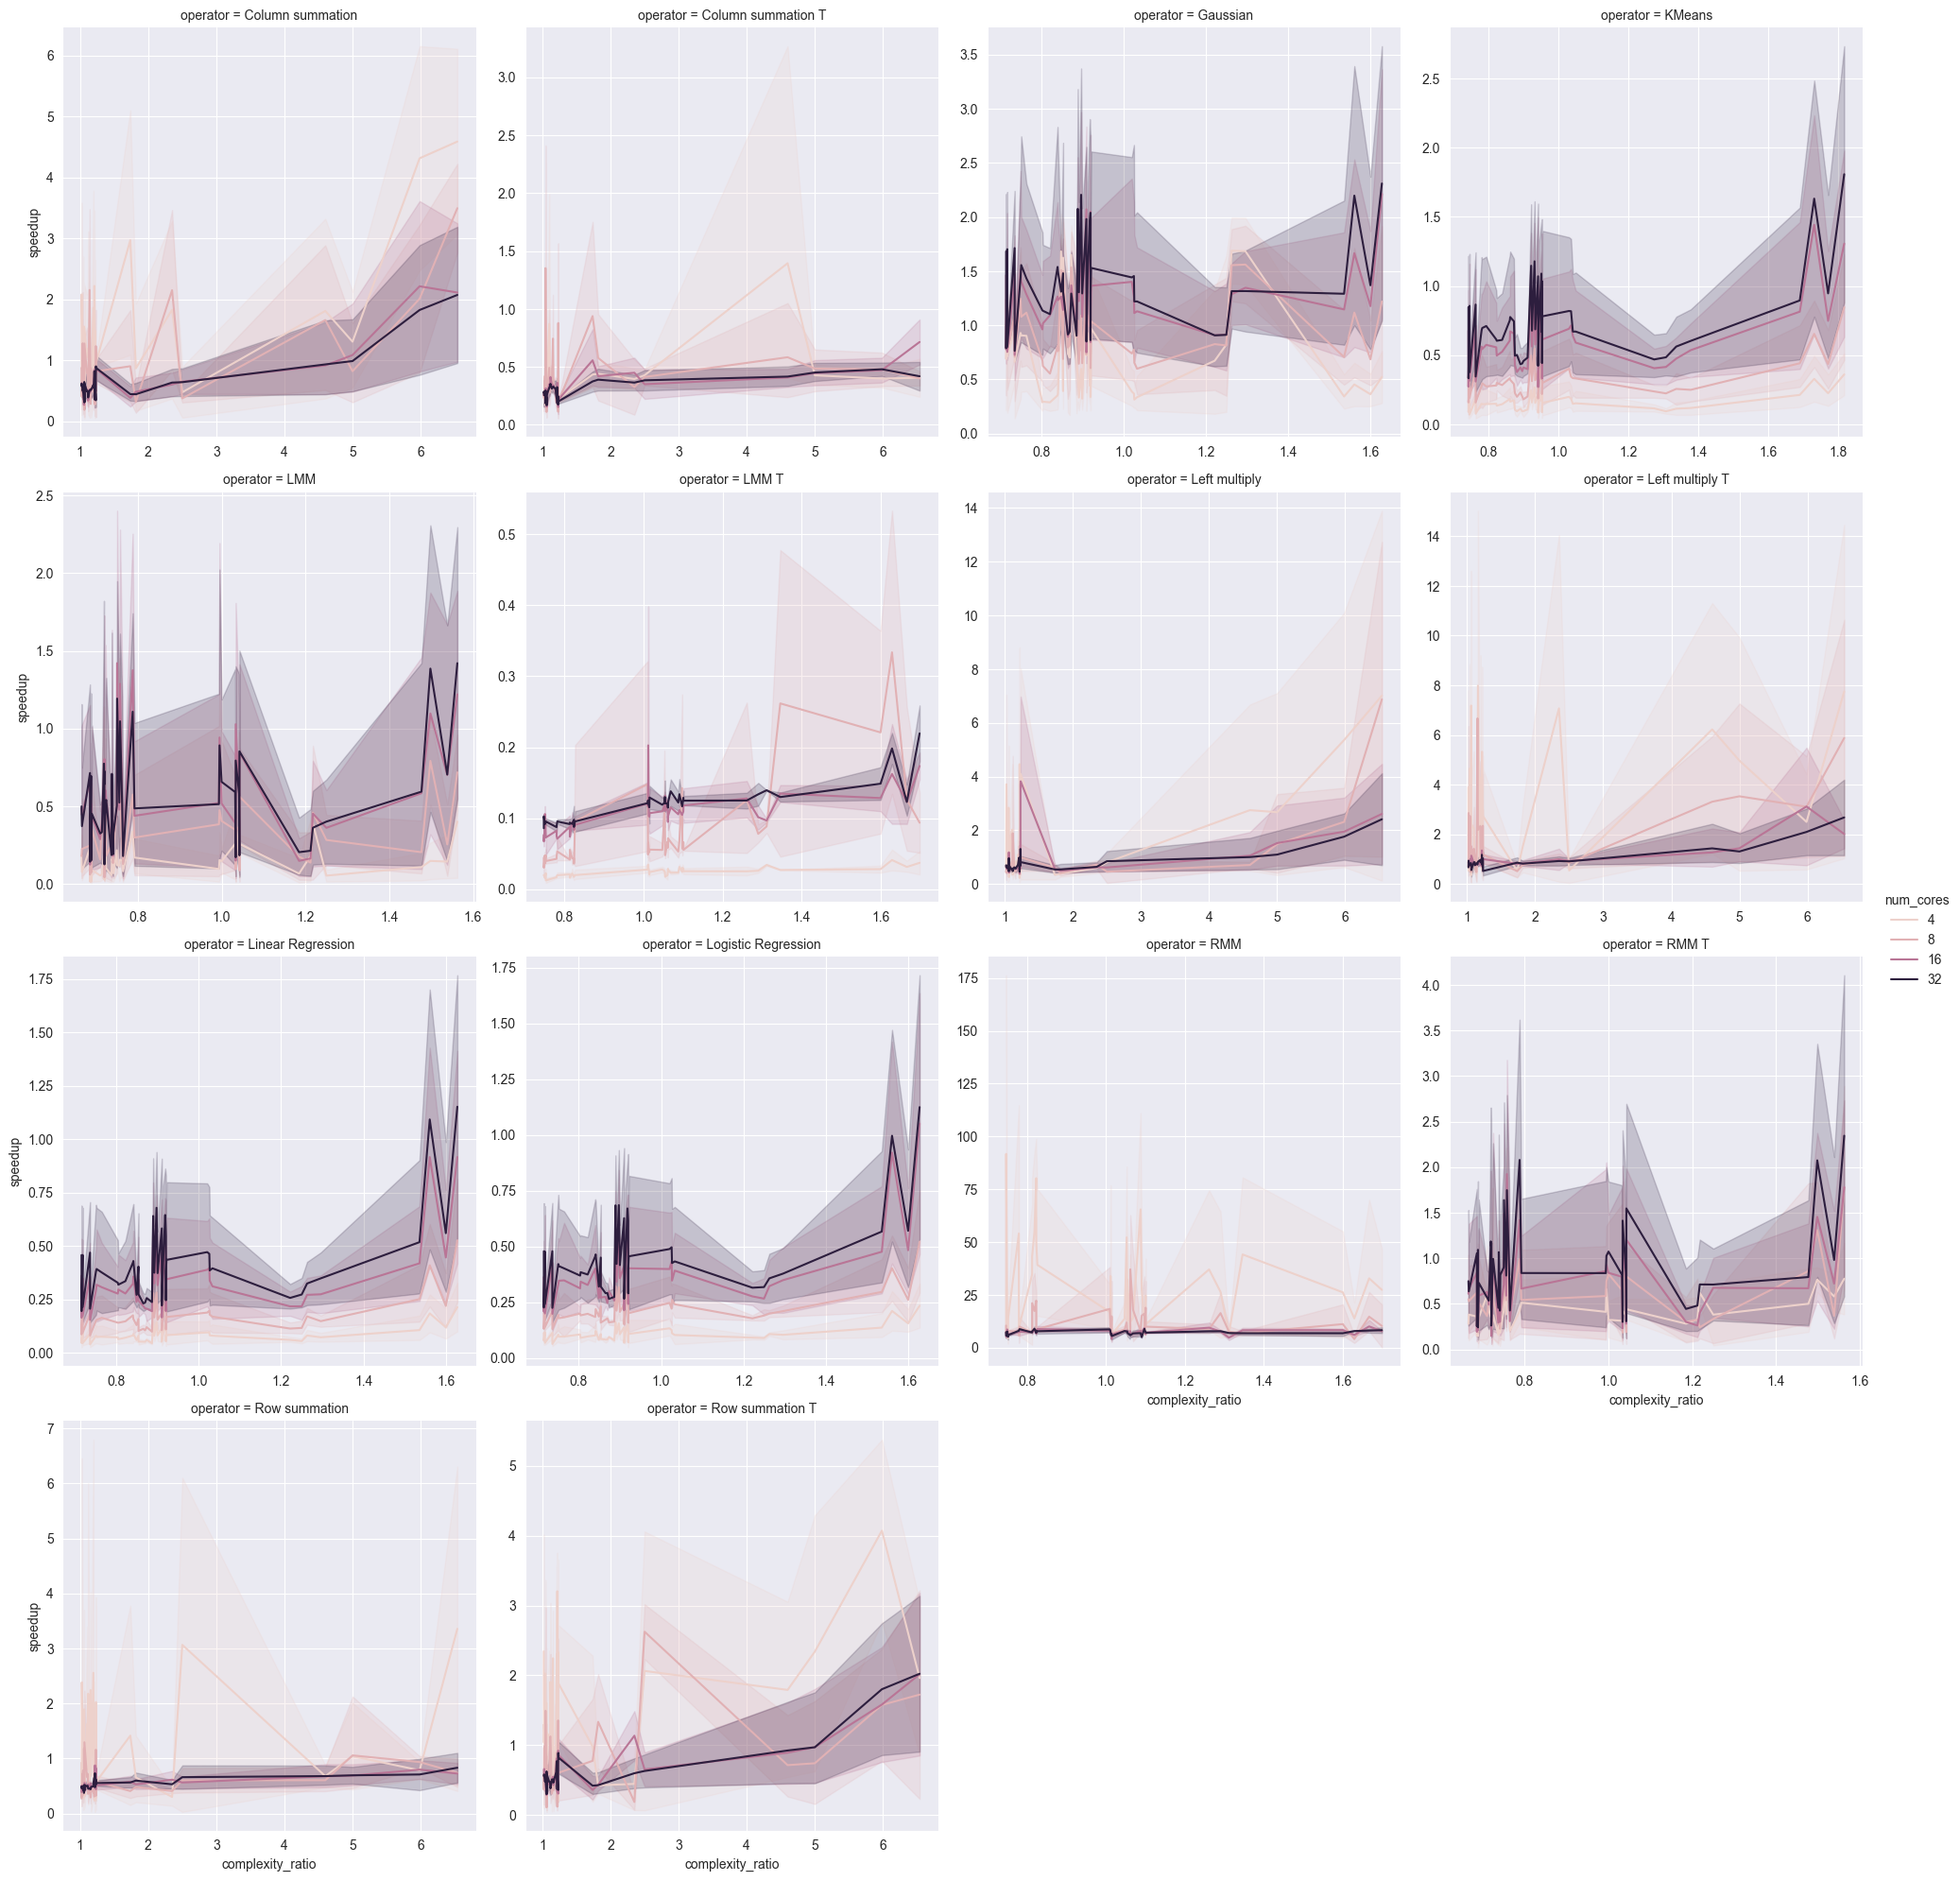

In [139]:
sns.relplot(kind='line', data=df[df.model == 'factorized'], hue='num_cores', y='speedup', x='complexity_ratio'
            , col='operator', col_wrap=4,facet_kws={'sharey': False, 'sharex': False}
            )

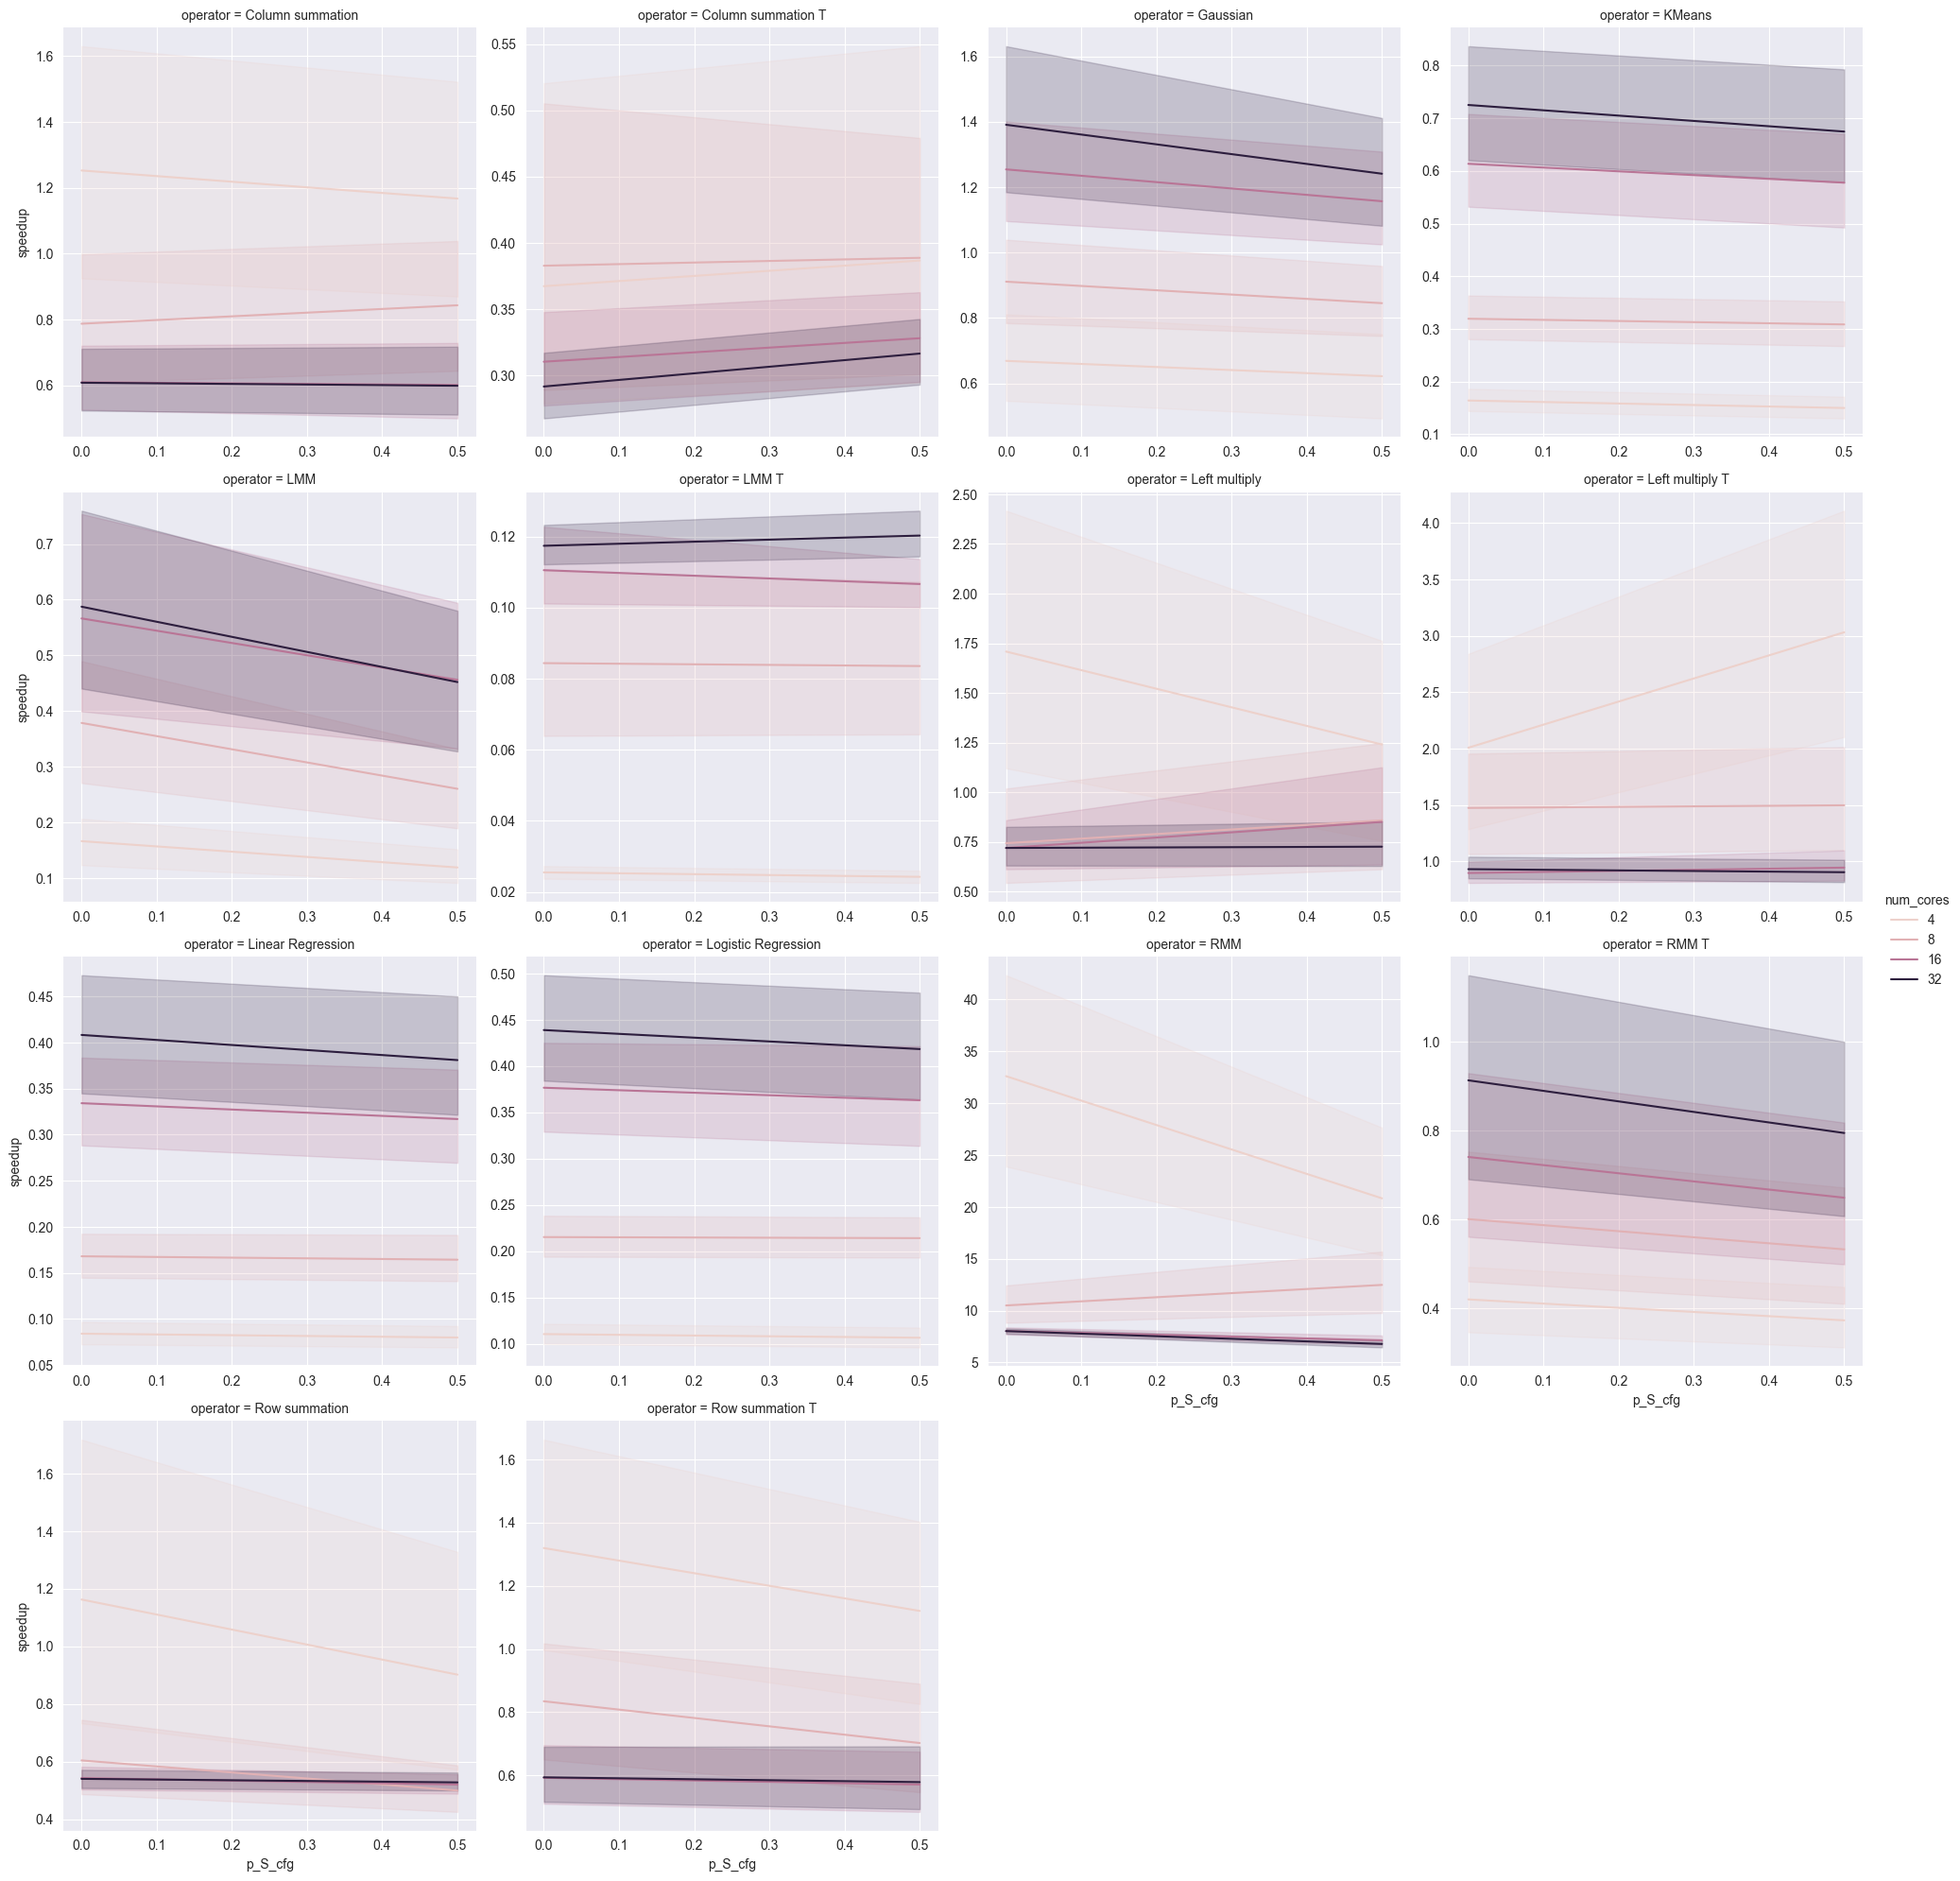

In [140]:
sns.relplot(kind='line', data=df[df.model == 'factorized'], hue='num_cores', y='speedup', x='p_S_cfg'
            , col='operator', col_wrap=4,facet_kws={'sharey': False, 'sharex': False}
            )

Text(0.5, 0.98, 'Speedup (relative to materialized) of ML operators, split per operator and number of CPU cores.')

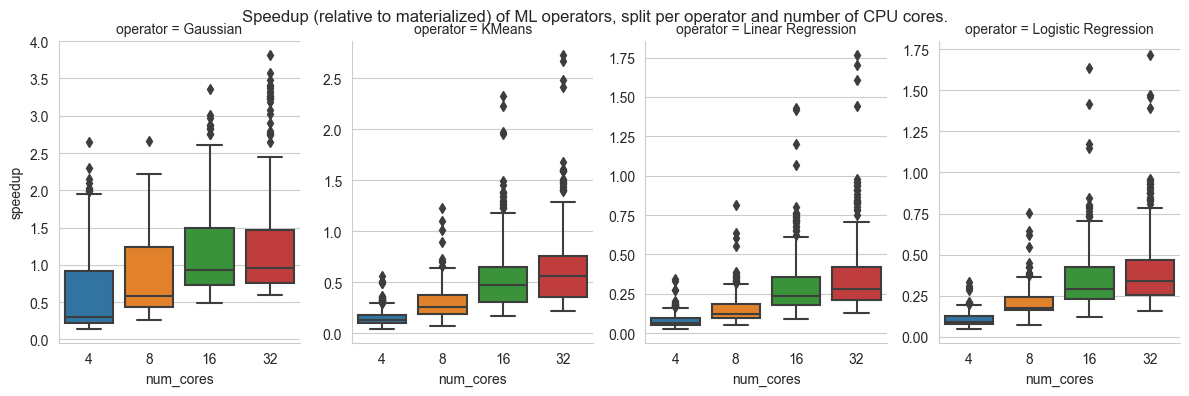

In [180]:
rp = sns.catplot(kind='box',data=df[(df.model == 'factorized') & (df.operator_type =='ML')], x='num_cores', y='speedup'
            , col='operator',
                 col_wrap=4,
                 sharey=False,
                height=4, aspect=3/4
                 )
rp.fig.subplots_adjust(top=0.9)
rp.fig.suptitle('Speedup (relative to materialized) of ML operators, split per operator and number of CPU cores.')

Text(0.5, 0.98, 'Speedup (relative to materialized) of LA operators, split per operator and number of CPU cores.')

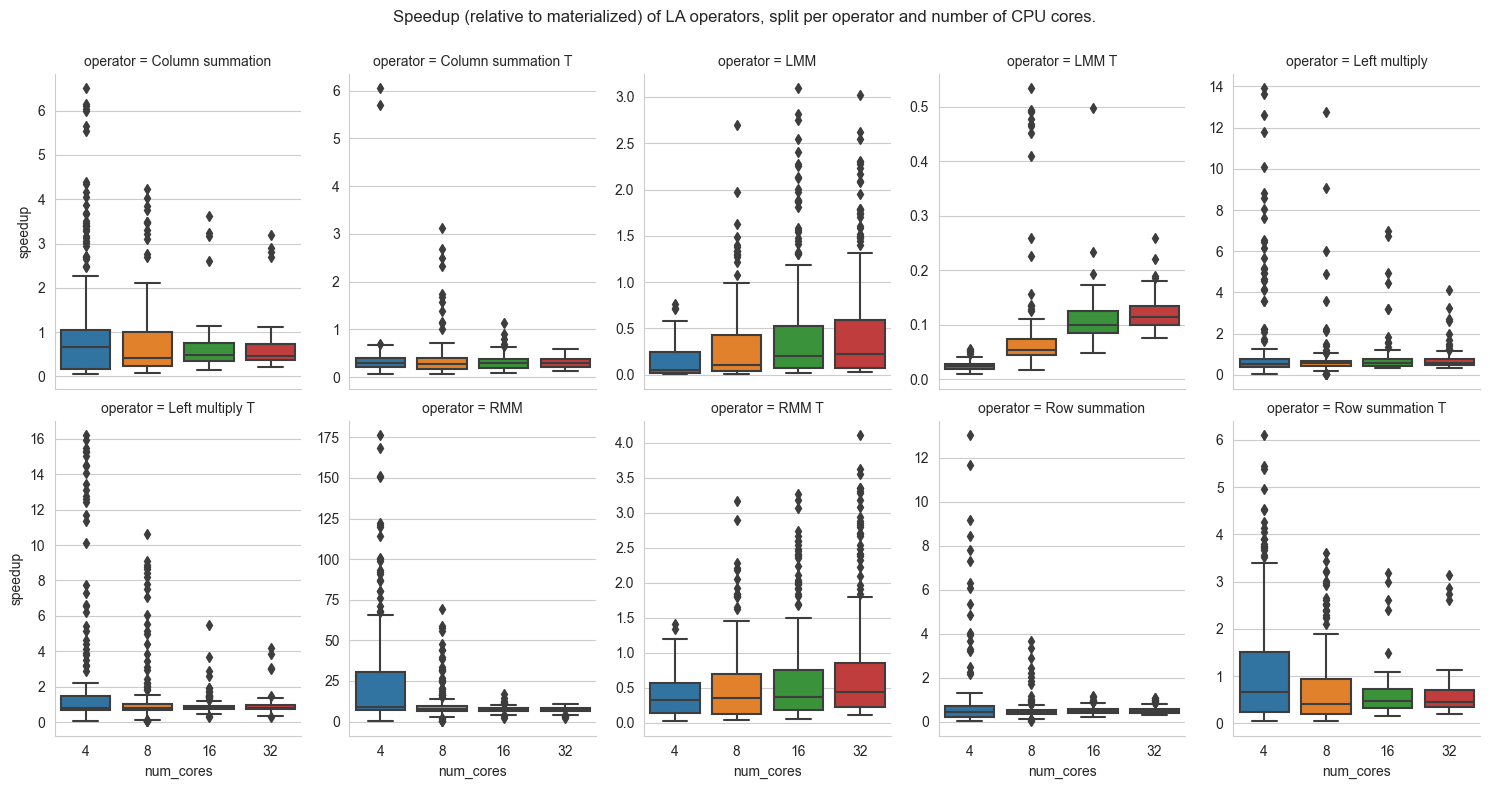

In [176]:
rp = sns.catplot(kind='box',data=df[(df.model == 'factorized') & (df.operator_type =='LA')], x='num_cores', y='speedup'
            , col='operator', col_wrap=5,sharey=False,
                height=4, aspect=3/4
                 )
rp.fig.subplots_adjust(top=0.9)
rp.fig.suptitle('Speedup (relative to materialized) of LA operators, split per operator and number of CPU cores.')

Text(0.5, 0.98, 'Speedup (relative to materialized) of ML operators vs the ratio of nonzero elements in factorized and materialized tables (higher means less nonzero elements in Factorized).')

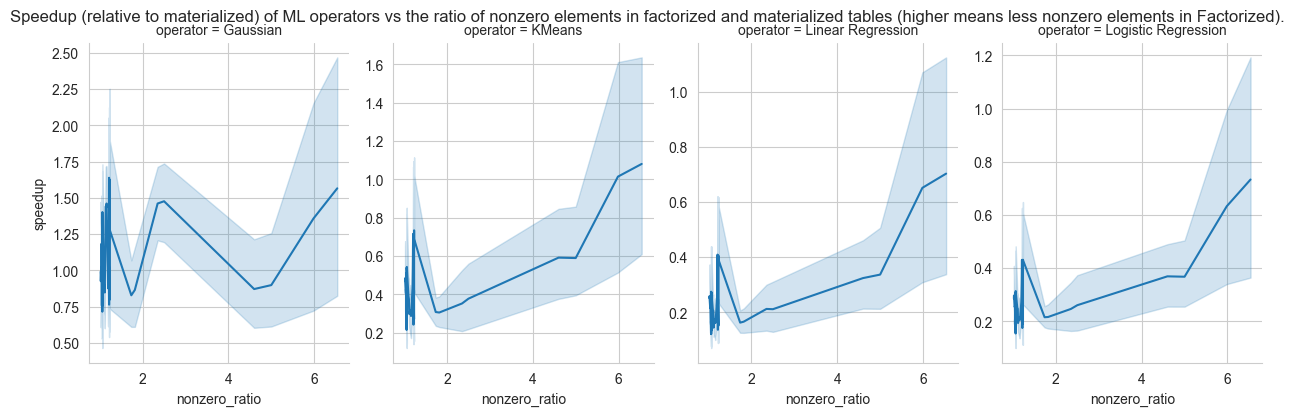

In [169]:
rp = sns.relplot(kind='line', data=df[(df.model == 'factorized') & (df.operator_type =='ML')],
                 # hue='num_cores',
                 y='speedup', x='nonzero_ratio', col='operator', col_wrap=4,facet_kws={'sharey': False, 'sharex': True},
                 height=4.2, aspect=3/4
                 )
rp.fig.subplots_adjust(top=0.9)
rp.fig.suptitle('Speedup (relative to materialized) of ML operators vs the ratio of nonzero elements in factorized and materialized tables (higher means less nonzero elements in Factorized).')

Text(0.5, 0.98, 'Speedup (relative to materialized) of ML operators vs the ratio of nonzero elements in factorized and materialized tables (higher means less nonzero elements in Factorized).')

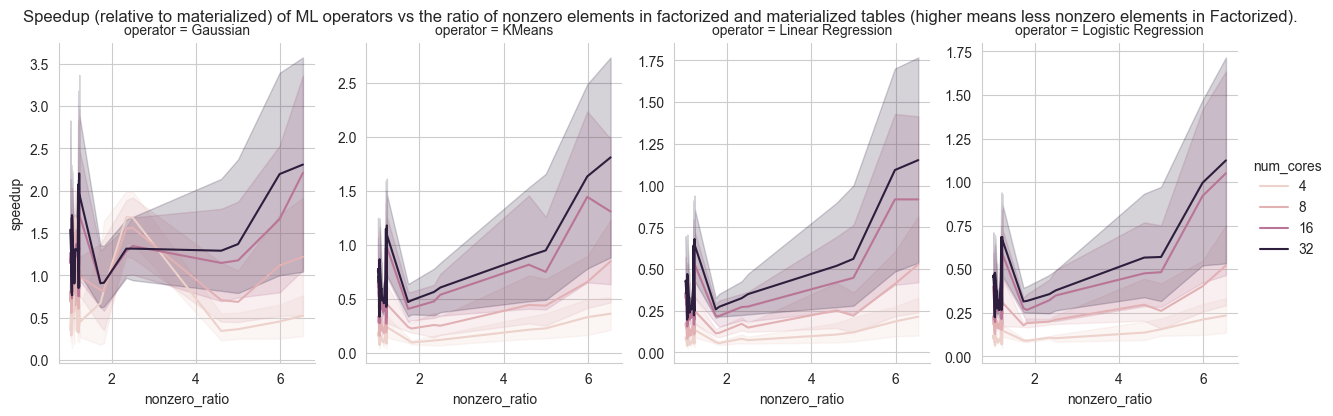

In [170]:
rp = sns.relplot(kind='line', data=df[(df.model == 'factorized') & (df.operator_type =='ML')],
                 hue='num_cores',
                 y='speedup', x='nonzero_ratio', col='operator', col_wrap=4,facet_kws={'sharey': False, 'sharex': True},
                 height=4.2, aspect=3/4)
rp.fig.subplots_adjust(top=0.9),
rp.fig.suptitle('Speedup (relative to materialized) of ML operators vs the ratio of nonzero elements in factorized and materialized tables (higher means less nonzero elements in Factorized).')

Text(0.5, 0.98, 'Speedup (relative to materialized) of LA operators vs the ratio of nonzero elements in factorized and materialized tables (higher means less nonzero elements in Factorized).')

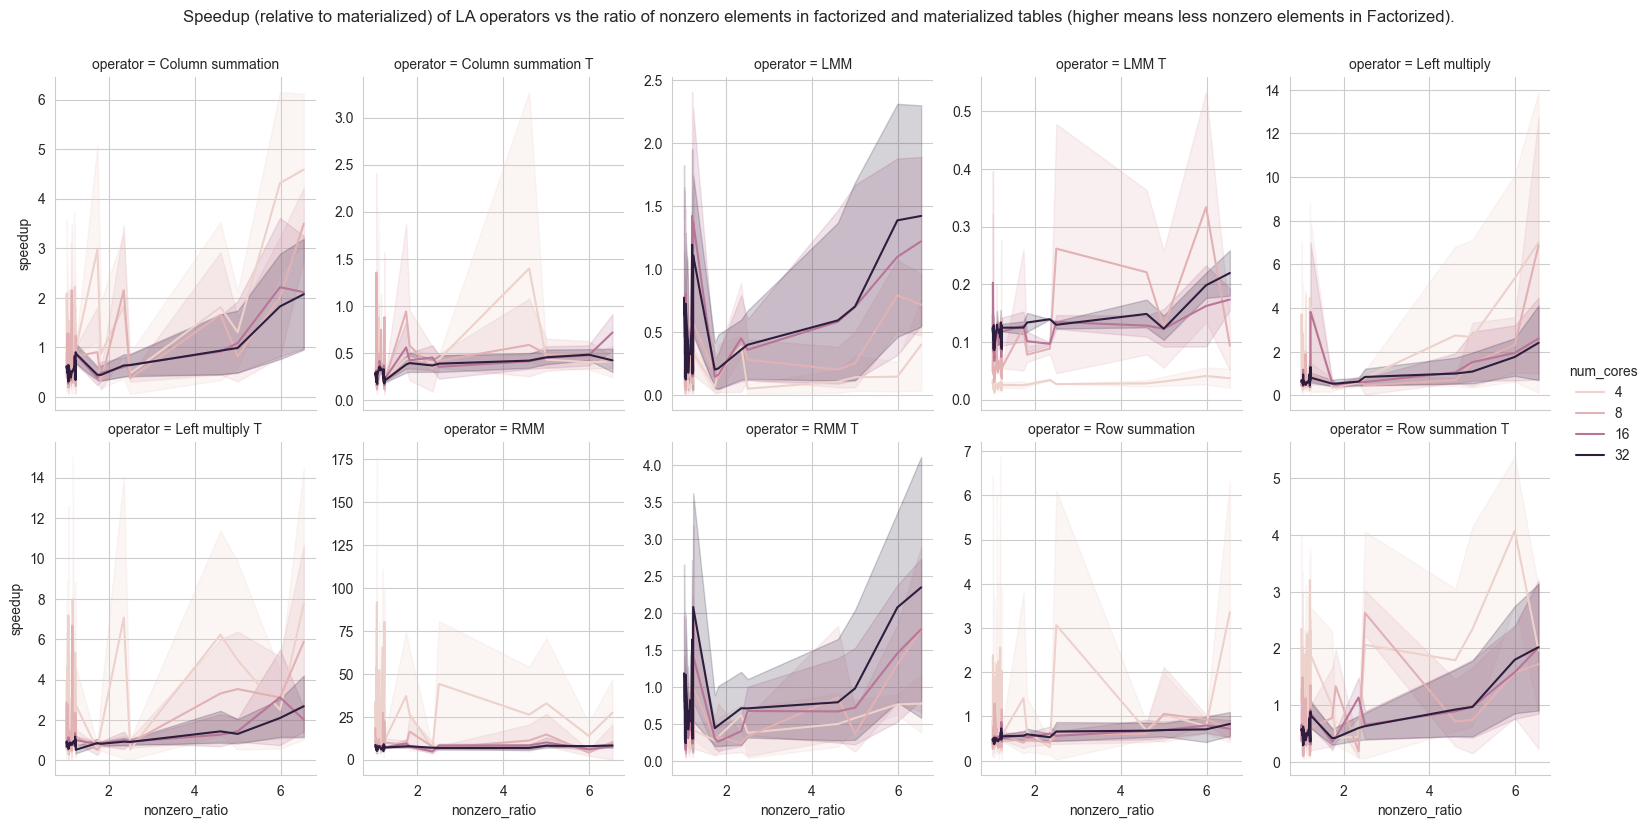

In [177]:
rp = sns.relplot(kind='line', data=df[(df.model == 'factorized') & (df.operator_type =='LA')],
                 hue='num_cores',
                 y='speedup', x='nonzero_ratio', col='operator', col_wrap=5,facet_kws={'sharey': False, 'sharex': True},
                 height=4.2, aspect=3/4)
rp.fig.subplots_adjust(top=0.9),
rp.fig.suptitle('Speedup (relative to materialized) of LA operators vs the ratio of nonzero elements in factorized and materialized tables (higher means less nonzero elements in Factorized).')

In [ ]:
independent_vars1 = ['join_y', 'operator', 'model', 'num_cores']
for col in df.columns:
    if col in independent_vars1:
        print(f"\n{col}")
        print(df[col].value_counts())

In [ ]:
independent_vars2 = ['tuple_ratio', 'feature_ratio', 'cardinality_T', 'cardinality_S', 'selectivity']
for col in df.columns:
    if col in independent_vars2:
        sns.displot(data=df, x=col).set(title=col)

In [ ]:
sns.displot(data=df, x='cardinality_T')

In [ ]:
# Mean runtime baseline vs amalur over number of cores per operator?
sns.catplot(kind='box', data=df, x='num_cores', y='speedup', hue='model', col='operator', col_wrap=4, sharey=False)